Run this cell first, and modify the `DIRECTORY` string as necessary

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
DIRECTORY = '/content/drive/MyDrive/2021_a_final/Github'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Licenses


In [ ]:
#@title ##### GraphNets License { form-width: "50%" }
# Copyright 2018 The GraphNets Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#    http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or  implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ============================================================================

In [ ]:
#@title ##### Modified Notice - MCMB Lab { form-width: "50%" }
# The GraphNets framework has been modified by:
# Multiscale Computational Mechanics and Biomechanics LAB (MCMB Lab)
# Department of Mechanical Engineering and Mechanics
# Drexel University, Philadelphia, Pennsylvania 
# Diroctor: Ahmad Raeisi Najafi (Ph.D.)
# All rights reserved.
# Developer: Nolan Black 10/2020
# Created in: 10/2020
# Last modified in: 12/2020
# ============================================================================

# Load Functions

In [ ]:
FUNCTIONS = '{}/Functions.ipynb'.format(DIRECTORY)
%run $FUNCTIONS

Installing Graph Nets library and dependencies:
Output message from command:

Tensor Flow Version: 1.15.5
GPU is NOT AVAILABLE


In [ ]:
def trim_input_informed_multiscale(input_list) :
  """
  simplify 1Hot IDs
  USE with FEA Mesh
  Nodes --> 5 attr, used to be 8
  Edges --> 4 attr, used to be 6
  19 nodes: [x, y, 1ux, 1uy, +-1Fx, +-1Fy, rho, 1surf, 1void, 
            1father_node, ux, uy, Fx, Fy, du_xx, du_yx, du_xy, du_yy, sig_vonmises]
  16 edges: [x, y, del_x, del_y, length, rho_edges, 1void, 
            del_ux, del_uy, del_Fx, del_Fy, del_du_xx, del_du_yx, del_du_xy, del_du_yy, del_sig_vonmises]
  """
  new_list = []
  for item in input_list :
    new_nodes = np.concatenate([item.nodes[..., 2:6], item.nodes[..., 9:12], item.nodes[..., 14:19]], axis = 1)
    new_edges = np.concatenate([item.edges[..., 2:5], item.edges[..., 7:9], item.edges[..., 11:16]], axis = 1)
    new_item = graphs.GraphsTuple(nodes=new_nodes,
              edges=new_edges,
              globals=item.globals,
              receivers=item.receivers,
              senders=item.senders,
              n_node=item.n_node,
              n_edge=item.n_edge)
    new_list.append(new_item)  
  return new_list


def normalize_input_list_informed_multiscale(input_list, input_stats) :

  # input_stats = [np.round(i, 12) for i in input_stats]
  node_means, node_stds, edge_means, edge_stds = input_stats

  local_mean_list = []
  local_std_list = []
  new_edge_list = []
  local_edge_mean_list = []
  local_edge_std_list = []
  for input_gt in input_list :
    # USE GLOBAL STATS
    input_gt.nodes[..., 0:2] = np.divide(np.subtract(input_gt.nodes[..., 0:2],  
                                                      node_means[0:2]), node_stds[0:2]) 
    input_gt.edges[..., 0:5] = np.divide(np.subtract(input_gt.edges[..., 0:5],  
                                                      edge_means[0:5]), edge_stds[0:5])

    # COLLECT LOCAL STATS
    father_means = np.mean(input_gt.nodes[..., 10:19], axis = 0)
    father_stds = np.round(np.std(input_gt.nodes[..., 10:19], axis = 0) , 12)
    father_edge_means = np.mean(input_gt.edges[..., 7:16], axis = 0)
    father_edge_stds = np.round(np.std(input_gt.edges[..., 7:16], axis = 0), 12)
    local_mean_list.append(father_means)
    local_std_list.append(father_stds)
    local_edge_mean_list.append(father_edge_means)
    local_edge_std_list.append(father_edge_stds)
    
    # LOCAL NORMALIZATION
    for i in range(len(input_gt.nodes[..., 0])) :
        input_gt.nodes[i, 10:12] = np.divide(np.subtract(input_gt.nodes[i, 10:12],  
                                                          father_means[0:2]), father_stds[0:2]) 
        input_gt.nodes[i, 14:19] = np.divide(np.subtract(input_gt.nodes[i, 14:19],  
                                                          father_means[4:9]), father_stds[4:9]) 

    for i in range(len(input_gt.edges[..., 0])) :
        input_gt.edges[i, 7:9] = np.divide(np.subtract(input_gt.edges[i, 7:9],  
                                                          father_edge_means[0:2]), father_edge_stds[0:2]) 
        input_gt.edges[i, 11:16] = np.divide(np.subtract(input_gt.edges[i, 11:16],  
                                                  father_edge_means[4:9]), father_edge_stds[4:9]) 

  
  return input_list, local_mean_list, local_std_list, local_edge_mean_list, local_edge_std_list
  

In [ ]:
def create_feed_dict(index, input_batch_list, sim_batch_list, mean_list, stds_list, edge_mean_list, edge_stds_list, 
                     input_ph, target_ph, means_ph, stds_ph, edge_means_ph, edge_stds_ph) :
    """
    !! Noise is still Experimental !!
    creates feed_dict for tf.session
    Inputs: graph_tuple lists, input stat lists, noise factors, placeholders
    Outputs: feed_dict
    """
    input_gt = input_batch_list[index]
    target_gt = sim_batch_list[index]
    means =  mean_list[index]
    stds =  stds_list[index]
    edge_means =  edge_mean_list[index]
    edge_stds =  edge_stds_list[index]

    feed_dict = {input_ph: input_gt, target_ph: target_gt, means_ph: means, stds_ph: stds, edge_means_ph: edge_means, edge_stds_ph: edge_stds}

    return feed_dict

def norm_01(x, mean, std) :
    ''' 
    0 mean, unit variance
    for use with tf.tensor inputs
    '''
    return tf.math.divide(tf.subtract(x, mean), std)

def inv_norm_01(y, mean, std) :
    ''' 
    Inverse from 0 mean, unit variance
    for use with tf.tensor inputs
    '''
    return tf.math.add(tf.multiply(y, std), mean)

def log10(x) :
  ten = tf.convert_to_tensor(10.0, dtype = tf.float64)
  return tf.math.log(x) / tf.math.log(ten)

def tanh_val(x, mu) :
  k = 1/ 8
  a = 4
  zero = tf.convert_to_tensor(1e-16, dtype = tf.float64)
  return a * tf.math.tanh(  k * log10(zero + tf.math.abs(x / mu)) )

# @tf.function - unnessary to decorate !!
def tf_du(input_op, output_ops) :
  with tf.GradientTape(persistent=True) as g:
    x  = input_op[0]
    # Tape keeps a record of these ops:
    g.watch(x)
    y = output_ops[0]
  du = g.batch_jacobian(y, x)
  return tf.cast(du, tf.float64)

def create_loss_ops(target_op, output_ops, local_mean, local_std, local_edge_mean, local_edge_std, 
                    target_stats) :
    """
   
    Nodes : [u_x, u_y, P_x, P_y, du11, du12, du21, du22, Sh]
    Edges : [del_length_x, del_length_y, length, delu11, delu12, delu21, delu22, Sh]
    
    stats = [x_mean_tr, x_std_tr, y_mean_tr, y_std_tr,
            du11_mean_tr, du11_std_tr, du12_mean_tr, du12_std_tr, du21_mean_tr, du21_std_tr, 
            du22_mean_tr, du22_std_tr, sh_mean_tr, sh_std_tr]

    """


    x_norm = norm_01(target_op.nodes[..., 0:1], local_mean[0], local_std[0])
    y_norm = norm_01(target_op.nodes[..., 1:2], local_mean[1], local_std[1])
    SE_x = (output_ops[0][..., 0:1] - x_norm)**2
    SE_y = (output_ops[0][..., 1:2] - y_norm)**2
    SE_uur = tf.reduce_mean(SE_x)  + tf.reduce_mean(SE_y)

    del_conv_x_norm = norm_01(target_op.edges[..., 0:1], local_edge_mean[0], local_edge_std[0])
    del_conv_y_norm = norm_01(target_op.edges[..., 1:2], local_edge_mean[1], local_edge_std[1])
    SE_del_conv_x = (output_ops[1][..., 0:1] - del_conv_x_norm)**2
    SE_del_conv_y = (output_ops[1][..., 1:2] - del_conv_y_norm)**2
    SE_del_conv_uur = tf.reduce_mean(SE_del_conv_x) + tf.reduce_mean(SE_del_conv_y) 

    loss_ops = tf.reduce_mean(SE_uur + SE_del_conv_uur)
                
    return loss_ops

In [ ]:
def create_batch_feed_dict(index, input_batch_list, sim_batch_list, mean_list, stds_list, edge_mean_list, edge_stds_list,
                     input_ph_batch, target_ph_batch, local_means_batch, local_stds_batch, local_edge_means_batch, local_edge_stds_batch) :
  """
  !! Noise is still Experimental !!
  creates feed_dict for tf.session
  Inputs: graph_tuple lists, input stat lists, noise factors, placeholders
  Outputs: feed_dict
  """


  input_feed = []
  target_feed = []
  mean_feed = []
  std_feed = []
  edge_mean_feed = []
  edge_std_feed = []
  for i in range(len(input_ph_batch)) :
    if i == 0 :
      input_gt = input_batch_list[index]
      target_gt = sim_batch_list[index]
      local_mean = mean_list[index]
      local_std = stds_list[index]
      local_edge_mean = edge_mean_list[index]
      local_edge_std = edge_stds_list[index]
    else :
      random_index = np.random.randint(0, len(input_batch_list))
      input_gt = input_batch_list[random_index]
      target_gt = sim_batch_list[random_index]
      local_mean = mean_list[random_index]
      local_std = stds_list[random_index]
      local_edge_mean = edge_mean_list[random_index]
      local_edge_std = edge_stds_list[random_index]
    
    input_feed.append(input_gt)
    target_feed.append(target_gt)
    mean_feed.append(local_mean)
    std_feed.append(local_std)
    edge_mean_feed.append(local_edge_mean)
    edge_std_feed.append(local_edge_std)

  ph_list = input_ph_batch + target_ph_batch + local_means_batch + local_stds_batch + local_edge_means_batch + local_edge_stds_batch
  feed_list = input_feed + target_feed + mean_feed + std_feed + edge_mean_feed + edge_std_feed

  return dict(zip(ph_list, feed_list))

def create_batch_loss_ops(target_ops, output_ops, local_means, local_stds, local_edge_means, local_edge_stds,
                          target_stats):
    """
    For a mini batch of 2 Examples 
    Create supervised loss operations from targets and outputs.
    Args:
    target_op: The simulated nodal displacement tf.Tensor.
    output_op: The list of output graphs from the model (spec'd as nodes).  


    """ 
             
    loss_ops = tf.reduce_mean([create_loss_ops(target_op, output_op, local_mean, local_std, local_edge_mean, local_edge_std,  target_stats) 
                              for target_op, output_op, local_mean, local_std, local_edge_mean, local_edge_std in zip(target_ops, output_ops, local_means, local_stds, local_edge_means, local_edge_stds )])
  
    return loss_ops 

In [ ]:
def uur_from_edges(input_gt, model_output, target_stats) :
  """
  returns nodal uur based on the calculated change in edge lengths
  """
  node_means, node_stds, edge_means, edge_stds = target_stats
  n_node = len(input_gt.nodes[...,0])
  n_edge = len(input_gt.edges[...,0])
  mod_x = model_output[1][..., 0] * edge_stds[0] + edge_means[0]
  mod_y = model_output[1][..., 1] * edge_stds[1] + edge_means[1] 
  for i in range(0, len(mod_x) , 2) :
    mod_x[i] = (mod_x[i] - mod_x[i+1]) / 2
    mod_x[i+1] = -mod_x[i]
    mod_y[i] = (mod_y[i] - mod_y[i+1]) / 2
    mod_y[i+1] = -mod_y[i]
  
  
  uur = np.zeros((n_node, 2))
  recorded = set()
  boundary = set()
  node_count = np.zeros((n_node, 1))
  for i in range(n_node) :
    # start with BC
    if input_gt.nodes[i, 0] == 1 :
      uur[i,0]= 0.0
      uur[i,1] = 0.0
      boundary.add(i)
      recorded.add(i)
      node_count[i] += 1
      # adjust nodes directly connected to boundary
      for e, (s, r) in enumerate(zip(input_gt.senders, input_gt.receivers)) :
        if s == i and r not in recorded and r not in boundary:
          uur[r, 0] = mod_x[e]
          uur[r, 1] = mod_y[e]
          recorded.add(r)
          node_count[r] += 1

  # loop over the rest of the nodes
  while len(recorded) < (n_node) :
    for e, (s, r) in enumerate(zip(input_gt.senders, input_gt.receivers)) :
      if s in recorded and r not in recorded :
        uur[r,0] = mod_x[e] + uur[s,0]
        uur[r,1] = mod_y[e] + uur[s,1]
        node_count[r] += 1
        recorded.add(r)

  # avg based on all input edge deltas
  while sum(node_count) < 2*(n_edge) :
    for e, (s, r) in enumerate(zip(input_gt.senders, input_gt.receivers)) :
      if (s in boundary and r not in boundary) or (s not in boundary and r not in boundary):
        node_count[r] += 1
        uur[r,0] += (mod_x[e] + uur[s,0])
        uur[r,1] += (mod_y[e] + uur[s,1])
        uur[r, ...] /= 2 
  return uur

def uur_from_nodes(input_gt, model_output, target_stats) :
  """ returns uur directly from nodes"""
  node_means, node_stds, edge_means, edge_stds = target_stats
  n_node = len(input_gt.nodes[...,0])
  n_edge = len(input_gt.edges[...,0])
  uur_node = np.zeros((n_node, 2))
  uur_node[..., 0] = model_output[0][..., 0] * node_stds[0] + node_means[0]
  uur_node[..., 1] = model_output[0][..., 1] * node_stds[1] + node_means[1] 

  return uur_node
def uur_from_local_nodes(input_gt, model_output, local_mean, local_std) :
  """ returns uur directly from nodes"""
  n_node = len(input_gt.nodes[...,0])
  n_edge = len(input_gt.edges[...,0])
  uur_node = np.zeros((n_node, 2))
  uur_node[..., 0] = model_output[0][..., 0] * local_std[0] + local_mean[0]
  uur_node[..., 1] = model_output[0][..., 1] * local_std[1] + local_mean[1]

  return uur_node


In [ ]:
def recover_system_nodes_edges(type_option, output_sub_graphist, graph_nodes, graph_edges,
                               local_mean_list, local_std_list, local_edge_mean_list, local_edge_std_list) :

  """RECOVER NODES, EDGES: 
  Input:
  output_sub_graphist = list of sub_graphs for a given body
  graph_nodes = node_idx from the given body
  graph_edges = edge_idx from the given body

  Shared attributes are averaged
  """
  if type_option == "target" :
    node_size = 18
    edge_size = 17
  if type_option == "input" :
    node_size = 12
    edge_size = 10
  if type_option == "projection" :
    node_size = 2
    edge_size = 2
  if type_option == "model" or type_option == "model_raw" :
    node_size = 2
    edge_size = 2
  if type_option == "loss" :
    node_size = 4
    edge_size = 17

  try :
    input_nodes =  np.concatenate([sub_graph["nodes"] for sub_graph in output_sub_graphist], axis = 0)
  except (AttributeError) :
    input_nodes =  np.concatenate([sub_graph.nodes for sub_graph in output_sub_graphist], axis = 0)   
  except :
    input_nodes =  np.concatenate([sub_graph[0] for sub_graph in output_sub_graphist], axis = 0)
  try :
    input_edges =  np.concatenate([sub_graph["edges"] for sub_graph in output_sub_graphist], axis = 0)
  except (AttributeError) :
    input_edges =  np.concatenate([sub_graph.edges for sub_graph in output_sub_graphist], axis = 0)
  except :
    input_edges =  np.concatenate([sub_graph[1][..., 0:edge_size] for sub_graph in output_sub_graphist], axis = 0)

  
  if type_option == "model" :
    input_nodes =  np.concatenate([sub_graph[0][..., 0:node_size]*(np.concatenate([(1)*std[0:node_size]])) + np.concatenate([mean[0:node_size]*1]) for sub_graph, std, mean in zip(output_sub_graphist, local_std_list, local_mean_list)], axis = 0)
    input_edges =  np.concatenate([(sub_graph[1][..., 0:edge_size]*1*std[0:edge_size] + 1*mean[0:edge_size]) for sub_graph, std, mean in zip(output_sub_graphist, local_edge_std_list, local_edge_mean_list)], axis = 0)
  if type_option == "model_raw" :
    input_nodes =  np.concatenate([sub_graph[0] for sub_graph in output_sub_graphist], axis = 0)
    input_edges =  np.concatenate([sub_graph[1] for sub_graph in output_sub_graphist], axis = 0)
  if type_option == "projection" :
    input_nodes =  np.concatenate([(sub_graph[0][..., 5:7]*std[0:2] + mean[0:2]) for sub_graph, std, mean in zip(output_sub_graphist, local_std_list, local_mean_list)], axis = 0)
    input_edges =  np.concatenate([(sub_graph[1][..., 3:5]*std[0:2] + mean[0:2])for sub_graph, std, mean in zip(output_sub_graphist, local_edge_std_list, local_edge_mean_list)], axis = 0)
      
  flat_graph_nodes = [item for sublist in graph_nodes for item in sublist]
  return_nodes = np.zeros((len(set(flat_graph_nodes)), node_size)) 
  node_count = np.zeros((len(set(flat_graph_nodes)), 1)) 
  for sub_node_id, node_id in enumerate(flat_graph_nodes) :
    node_count[node_id] += 1
    if node_count[node_id] == 1 :
      return_nodes[node_id, ...] = input_nodes[sub_node_id, ...]
    else : 
      return_nodes[node_id, ...] += input_nodes[sub_node_id, ...]
      return_nodes[node_id, ...] /= 2
  
  flat_graph_edges = [item for sublist in graph_edges for item in sublist]
  return_edges = np.zeros((len(set(flat_graph_edges)), edge_size)) 
  edge_count = np.zeros((len(set(flat_graph_edges)), 1)) 
  for sub_edge_id, edge_id in enumerate(flat_graph_edges) :
    edge_count[edge_id] += 1
    if edge_count[edge_id] == 1 :
      return_edges[edge_id, ...] = input_edges[sub_edge_id, ...]
    else : 
      return_edges[edge_id, ...] += input_edges[sub_edge_id, ...]
      return_edges[edge_id, ...] /= 2
    
  return return_nodes, return_edges

def return_senders_receivers(output_sub_graphist, graph_nodes, graph_edges) :

  input_receivers = []
  input_senders = []
  for sub_graph in range(len(output_sub_graphist)) :
    global_senders = copy.deepcopy(output_sub_graphist[sub_graph]["senders"])
    global_receivers = copy.deepcopy(output_sub_graphist[sub_graph]["receivers"])
    sub_graph_list_keys = graph_nodes[sub_graph]

    for i, val in enumerate(fea_sub_graph_list[sub_graph]["senders"] ) :
      global_senders[i] = sub_graph_list_keys[val]
    for i, val in enumerate(fea_sub_graph_list[sub_graph]["receivers"] ) :
      global_receivers[i] = sub_graph_list_keys[val]

    input_receivers += global_receivers
    input_senders += global_senders

  flat_graph_edges = [item for sublist in graph_edges for item in sublist]
  return_sends = np.zeros((len(set(flat_graph_edges)), )) 
  return_recs = np.zeros((len(set(flat_graph_edges)), )) 
  for sub_edge_id, edge_id in enumerate(flat_graph_edges) :
    return_recs[edge_id] = int(input_receivers[sub_edge_id])
    return_sends[edge_id] = int(input_senders[sub_edge_id])

  return return_recs, return_sends


# **Setup Training**

In [ ]:
#Initialize model and domain
# reset the default graph and set seed for randmoization
tf.reset_default_graph()
rand = np.random.RandomState(SEED)

# Model parameters - 
# See GraphNets Library.
model = EncodeProcessDecode(latent_size = 128,
                            mlp_hidden_size = 128,
                            mlp_num_hidden_layers = 2,
                            num_message_passing_steps = 5,
                            output_size = 2)
########################################################################

dirname = 'MFGNN_1BC'
model_name = "Model_F1"


########################################################################
# Prep input
with open('{}/Models/{}/input_stats'.format(DIRECTORY, dirname), 'rb') as f :
  input_stats = dill.load(f)
with open('{}/Models/{}/output_stats'.format(DIRECTORY, dirname), 'rb') as f :
  target_stats = dill.load(f)



## Test Examples

In [ ]:
# Domain initialization
# mesh is m1 elements along x, m2 elements along y
# mesh defined by m1 x m2, convergence near 40 x 20
elem_type = "quad" # "tri" or "quad"
bound_x = (0.0, 2.0)
bound_y = (-0.5, 0.5)
E = 200e9
v = 0.3

force_dofs = [0, 1]
force_vals = [0, -1e7]
body_force = [0.0, 0.0]
vol_frac_min_max = (1.0, 1.0)
density_min_max = (1.0, 1.0)
support_options = ["left_cantilever"] # ["left_cantilever", "right_cantilever", "dual_cantilever", "MBB"]
force_options = ["side_center"] # ["side_center", "side_bottom", "side_top", "top_center", "top_distributed"]
multi_fidelity_opt, KUR_opt, random_bound_opt, random_force_opt = True, False, False, False
force_scale = (-1.0, 1.0)
batch_size_tr = 1
########################################################################

# Gen params 0.
data_size_0_ge = 1
batch_size_0_ge = 1
m1_min_max_0_ge = (8, 9) 
m2_min_max_0_ge = (4, 5) 
refine_fact_0_ge = (0.0, 0.0) 
coord_noise_min_max_0_ge = (0.0, 0.0)
noise_type_0_ge = "posi" 

# Gen Params 1.
data_size_1_ge = 1
batch_size_1_ge = 1
m1_min_max_1_ge = (8, 9) 
m2_min_max_1_ge = (4, 5) 
refine_fact_1_ge = (0.0, 0.0) 
coord_noise_min_max_1_ge = (0.0, 0.0)
noise_type_1_ge = "posi" 


# Gen Params 2.
data_size_2_ge = 1
batch_size_2_ge = 1
m1_min_max_2_ge = (8, 9) 
m2_min_max_2_ge = (4, 5) 
refine_fact_2_ge = (0.0, 0.0) 
coord_noise_min_max_2_ge = (0.0, 0.0)
noise_type_2_ge = "posi" 

########################################################################
test_start_time = time.time()


# Test data 0.
multiscale_min_max_m1 = (2, 4) 
multiscale_min_max_m2 = (2, 4) 
raw_0_ge, input_graph_list_0_ge, simulated_graph_list_0_ge, graph_recovery_0_ge = generate_data(
    data_size_0_ge, m1_min_max_0_ge, m2_min_max_0_ge, refine_fact_0_ge, vol_frac_min_max, density_min_max, noise_type_0_ge, coord_noise_min_max_0_ge,
    support_options, force_options, multi_fidelity_opt, KUR_opt, random_bound_opt, random_force_opt,
     elem_type, bound_x, bound_y, E, v, force_vals, force_dofs, body_force,
     multiscale_min_max_m1, multiscale_min_max_m2, force_scale)  
initial_conditions_0_ge, true_deformation_0_ge = generate_raw_data(input_graph_list_0_ge, simulated_graph_list_0_ge ,
                                                                              batch_size_0_ge + 1)

multiscale_min_max_m1 = (4, 8) 
multiscale_min_max_m2 = (4, 8) 
# Test data 1.
raw_1_ge, input_graph_list_1_ge, simulated_graph_list_1_ge, graph_recovery_1_ge = generate_data(
    data_size_1_ge, m1_min_max_1_ge, m2_min_max_1_ge, refine_fact_1_ge, vol_frac_min_max, density_min_max, noise_type_1_ge, coord_noise_min_max_1_ge,
    support_options, force_options, multi_fidelity_opt, KUR_opt, random_bound_opt, random_force_opt,
     elem_type, bound_x, bound_y, E, v, force_vals, force_dofs, body_force,
     multiscale_min_max_m1, multiscale_min_max_m2, force_scale)    
initial_conditions_1_ge, true_deformation_1_ge = generate_raw_data(input_graph_list_1_ge, simulated_graph_list_1_ge,
                                                                              batch_size_1_ge + 1)

multiscale_min_max_m1 = (4, 8) 
multiscale_min_max_m2 = (4, 8) 
support_options = ["right_cantilever"]
# Test data 2.
raw_2_ge, input_graph_list_2_ge, simulated_graph_list_2_ge, graph_recovery_2_ge = generate_data(
    data_size_2_ge, m1_min_max_2_ge, m2_min_max_2_ge, refine_fact_2_ge, vol_frac_min_max, density_min_max, noise_type_2_ge, coord_noise_min_max_2_ge,
    support_options, force_options, multi_fidelity_opt, KUR_opt, random_bound_opt, random_force_opt,
     elem_type, bound_x, bound_y, E, v, force_vals, force_dofs, body_force,
     multiscale_min_max_m1, multiscale_min_max_m2, force_scale)  
initial_conditions_2_ge, true_deformation_2_ge = generate_raw_data(input_graph_list_2_ge, simulated_graph_list_2_ge,
                                                                              batch_size_2_ge + 1)

  
test_time = time.time() - test_start_time
print("Test data ready in {}m {}s".format(int(test_time//60), int(test_time % 60)))


Stat mesh: 8 x 4 || Father mesh: 16 x 8 || Child mesh: 32 x 16 || Force Vals: 0.0000, -10000000.0000 || left_cantilever, side_center || (0.0, 2.0) x (-0.5, 0.5)
Projection Error: avg 0.0629, max 0.8666, min -0.2804
Pass:  0.0005374325883301306
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Stat mesh: 8 x 4 || Father mesh: 32 x 16 || Child mesh: 224 x 64 || Force Vals: 0.0000, -10000000.0000 || left_cantilever, side_center || (0.0, 2.0) x (-0.5, 0.5)
Projection Error: avg 0.0426, max 6.0155, min -0.4155
Pass:  0.0005389708227225174

Stat mesh: 8 x 4 || Father mesh: 32 x 16 || Child mesh: 128 x 64 || Force Vals: 0.0000, -10000000.0000 || right_cantilever, side_center || (0.0, 2.0) x (-0.5, 0.5)
Projection Error: avg 0.0386, max 2.5704, min -0.4519
Pass:  0.0005389072593555502
Test data ready in 4m 14s


# **Optimizer Settings**

In [ ]:
# Prep for tf.session
start_time = time.time()
input_ph = initial_conditions_0_ge[-1]
input_pass = graphs.GraphsTuple(nodes = input_ph.nodes[..., 0:12], # 12
                              edges =  input_ph.edges[..., 0:10],
                              globals = input_ph.globals,
                              senders = input_ph.senders,
                              receivers = input_ph.receivers,
                              n_node = input_ph.n_node,
                              n_edge = input_ph.n_edge)
initial_conditions_ph = utils_tf._placeholders_from_graphs_tuple(input_pass)
target_ph = true_deformation_0_ge[-1]
true_deformation_ph = utils_tf._placeholders_from_graphs_tuple(target_ph)
local_means_ph = tf.placeholder(tf.float64, shape = (9,))
local_stds_ph = tf.placeholder(tf.float64, shape = (9,))
local_edge_means_ph = tf.placeholder(tf.float64, shape = (9,))
local_edge_stds_ph = tf.placeholder(tf.float64, shape = (9,))

BATCH_SIZE = 2
input_ph_batch = [utils_tf._placeholders_from_graphs_tuple(input_pass)] * BATCH_SIZE
target_ph_batch = [utils_tf._placeholders_from_graphs_tuple(target_ph)] * BATCH_SIZE
local_means_batch = [tf.placeholder(tf.float64, shape = (9,))] * BATCH_SIZE
local_stds_batch = [tf.placeholder(tf.float64, shape = (9,))] * BATCH_SIZE
local_edge_means_batch = [tf.placeholder(tf.float64, shape = (9,))] * BATCH_SIZE
local_edge_stds_batch = [tf.placeholder(tf.float64, shape = (9,))] * BATCH_SIZE
output_ops_batch = [model(in_ph) for in_ph in input_ph_batch]

loss_ops_batch = create_batch_loss_ops(target_ph_batch, output_ops_batch,  local_means_batch, local_stds_batch, local_edge_means_batch, local_edge_stds_batch,
                                       target_stats)

output_ops_0_ge = model(initial_conditions_ph)
loss_op_0_ge = (create_loss_ops(true_deformation_ph, output_ops_0_ge,  local_means_ph, local_stds_ph, local_edge_means_ph, local_edge_stds_ph, 
                                   target_stats))

output_ops_1_ge = model(initial_conditions_ph)
loss_op_1_ge = (create_loss_ops(true_deformation_ph, output_ops_1_ge,  local_means_ph, local_stds_ph, local_edge_means_ph, local_edge_stds_ph, 
                                   target_stats))

output_ops_2_ge = model(initial_conditions_ph)
loss_op_2_ge = (create_loss_ops(true_deformation_ph, output_ops_2_ge,  local_means_ph, local_stds_ph, local_edge_means_ph, local_edge_stds_ph, 
                                  target_stats))

initial_conditions_ph, true_deformation_ph = make_all_runnable_in_session(initial_conditions_ph, true_deformation_ph)


########################################################################
# Optimizer.

print("Setting optimizer...")

num_training_iterations = int(6e6) # 
starter_learning_rate = 1e-4
min_learning_rate = 1e-6
decay_steps = int(2e6) 
decay_rate = 0.1

global_step = tf.Variable(0, trainable=False)
learning_rate = tf.compat.v1.train.exponential_decay(
    learning_rate = starter_learning_rate - min_learning_rate, 
    global_step = global_step * batch_size_tr,
    decay_steps = decay_steps, 
    decay_rate = decay_rate,
    staircase = False
) +min_learning_rate
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
step_op_batch = optimizer.minimize(loss_ops_batch, global_step=global_step)

net_time0 = time.time() - start_time
print("Optimizer ready in {}m {}s".format(int(net_time0//60), int(net_time0 % 60)))

try:
  sess.close()
except NameError:
  pass

try:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  # Invalid device or cannot modify virtual devices once initialized.
  pass

config = tf.ConfigProto()
#config.allow_soft_placement=True
#config.log_device_placement=True
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.9


sess = tf.Session(config = config)
sess.run(tf.global_variables_initializer())
net_time1 = time.time() - start_time - net_time0
print("Sess ready in {}m {}s".format(int(net_time1//60), int(net_time1 % 60)))

saver = tf.train.Saver()
save_every = int(0.1e5)

input_graph_0_ge = sess.run(initial_conditions_0_ge)
target_0_ge = sess.run(true_deformation_0_ge)
input_graph_0_ge, local_means_0_ge, local_stds_0_ge, local_edge_means_0_ge, local_edge_stds_0_ge = normalize_input_list_informed_multiscale(input_graph_0_ge, input_stats)
input_graph_0_ge = trim_input_informed_multiscale(input_graph_0_ge)


input_graph_1_ge = sess.run(initial_conditions_1_ge)
target_1_ge = sess.run(true_deformation_1_ge)
input_graph_1_ge, local_means_1_ge,local_stds_1_ge, local_edge_means_1_ge, local_edge_stds_1_ge = normalize_input_list_informed_multiscale(input_graph_1_ge, input_stats)
input_graph_1_ge = trim_input_informed_multiscale(input_graph_1_ge)

input_graph_2_ge = sess.run(initial_conditions_2_ge)
target_2_ge = sess.run(true_deformation_2_ge)
input_graph_2_ge, local_means_2_ge,local_stds_2_ge, local_edge_means_2_ge, local_edge_stds_2_ge = normalize_input_list_informed_multiscale(input_graph_2_ge, input_stats)
input_graph_2_ge= trim_input_informed_multiscale(input_graph_2_ge)

print("Resetting training...")

last_iteration = 0
losses_tr = []
inputs_tr = []
targets_tr = []
outputs_tr = []
avg_tr = []

logged_iterations = []
logged_iter = -1
logged_losses_tr = []
losses_0_ge = []
avg_logged_0_ge = []
losses_1_ge = []
avg_logged_1_ge = []
losses_2_ge = []
avg_logged_2_ge = []

avg_err_0_ge_list = []
avg_err_1_ge_list = []
avg_err_2_ge_list = []

net_time = time.time() - start_time
print("...Complete Optimizer ready in {}m {}s".format(int(net_time//60), int(net_time % 60)))


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Setting optimizer...


/usr/local/lib/python3.7/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.7/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.7/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.7/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting spars

Optimizer ready in 0m 9s
Sess ready in 0m 1s
Resetting training...
...Complete Optimizer ready in 0m 17s


# **Restore Model**

In [ ]:
restore_iter = int(200e4)
model_name_restore = "Model_F1"
saver.restore(sess, "{}/Models/{}/{}/-{}".format(DIRECTORY, dirname, model_name_restore, restore_iter)) 
last_iteration = restore_iter + 1
model_name = model_name_restore

with open('{}/Models/{}/{}/losses_0_ge'.format(DIRECTORY, dirname, model_name), 'rb') as f :
  losses_0_ge = dill.load(f)
with open('{}/Models/{}/{}/avg_err_0_ge'.format(DIRECTORY, dirname, model_name), 'rb') as f :
  avg_err_0_ge_list = dill.load(f)
with open('{}/Models/{}/{}/losses_1_ge'.format(DIRECTORY, dirname, model_name), 'rb') as f :
  losses_1_ge = dill.load(f)
with open('{}/Models/{}/{}/avg_err_1_ge'.format(DIRECTORY, dirname, model_name), 'rb') as f :
  avg_err_1_ge_list = dill.load(f)
with open('{}/Models/{}/{}/losses_2_ge'.format(DIRECTORY, dirname, model_name), 'rb') as f :
  losses_2_ge = dill.load(f)
with open('{}/Models/{}/{}/avg_err_2_ge'.format(DIRECTORY, dirname, model_name), 'rb') as f :
  avg_err_2_ge_list = dill.load(f)
    

INFO:tensorflow:Restoring parameters from /content/drive/MyDrive/2021_a_final/Github/Models/MFGNN_1BC/Model_F1/-2000000


# Mini Batch Training
Execute these cells ONLY IF you have used DataGeneration.ipynb to pre-generate and store training data graphs in the current directory. Note that saving is automatic and may overwrite the existing model. The training loop may be stopped and restarted at any time without reinitializing the model, however the "setup training" and "optimizer cells" will erase any progress if they are re-run.

In [ ]:
start_time = time.time()
print("Loading Training data....")

# Data / training parameters.
fetches = 10
load_idx = 0
old_load_idx = load_idx
batch_size_tr = 1

fetched_inputs = []
fetched_targets = []
fetched_recovery = []
for load_idx in range(fetches) :
  with open('/content/drive/MyDrive/2021_a_final/{}/inputs/{}'.format(dirname, load_idx), 'rb') as f :
    f_in = dill.load(f)
  with open('/content/drive/MyDrive/2021_a_final/{}/outputs/{}'.format(dirname, load_idx), 'rb') as f :
    f_out = dill.load(f)
  with open('/content/drive/MyDrive/2021_a_final/{}/recovery/{}'.format(dirname, load_idx), 'rb') as f :
    f_rec = dill.load(f)
  fetched_inputs += (f_in)
  fetched_targets += (f_out)
  fetched_recovery += (f_rec)
data_size_tr = len(fetched_inputs)
fetch_size = data_size_tr


fetched_inputs, local_means_tr, local_stds_tr, local_edge_means_tr, local_edge_stds_tr = normalize_input_list_informed_multiscale(
    fetched_inputs, input_stats)
fetched_inputs = trim_input_informed_multiscale(fetched_inputs)

net_time = time.time() - start_time
print("Training data ready in {}m {}s".format(int(net_time//60), int(net_time % 60)))

In [ ]:
log_every_seconds = 20
print("# (iter), T (sec), "
      "        Ltr Train,   "
      "                Lge0 Test, "
      "              Lge1 Gen")
start_time = time.time()
last_log_time = start_time

for iteration in range(last_iteration, num_training_iterations):

  last_iteration = iteration
  global_step = iteration
  global_iteration = iteration

  idx_tr = int(iteration % (data_size_tr/batch_size_tr))
  load_idx = int(idx_tr // fetch_size)
  fetch_idx = idx_tr 

  batch_feed = create_batch_feed_dict(fetch_idx, fetched_inputs, fetched_targets, local_means_tr, local_stds_tr, local_edge_means_tr, local_edge_stds_tr,
                     input_ph_batch, target_ph_batch, local_means_batch, local_stds_batch, local_edge_means_batch, local_edge_stds_batch) 

  train_values = sess.run({
      "targets": target_ph_batch,
      "outputs": output_ops_batch,
      "loss": loss_ops_batch,
      "step": step_op_batch
      }, feed_dict = batch_feed)

  losses_tr.append(train_values["loss"])


  ########################################################################
  the_time = time.time()
  elapsed_since_last_log = the_time - last_log_time
  if elapsed_since_last_log > log_every_seconds:
    last_log_time = the_time
    logged_iter += 1
    logged_losses_tr.append(train_values["loss"])
    logged_iterations.append(iteration)
    
    if logged_iter >= 1:
        avg_span = logged_iterations[-1] - logged_iterations[-2]
    else :
        avg_span = 1
    avg_tr.append(sum(losses_tr[-1: -(avg_span + 1): -1])/avg_span)
    losses_tr = []
    
    
    idx_0_ge = int(logged_iter % (data_size_0_ge/batch_size_0_ge))
    feed_dict_0_ge = create_feed_dict(idx_0_ge, input_graph_0_ge, target_0_ge, local_means_0_ge, local_stds_0_ge, local_edge_means_0_ge, local_edge_stds_0_ge,
                               initial_conditions_ph, true_deformation_ph, local_means_ph, local_stds_ph, local_edge_means_ph, local_edge_stds_ph)
    test_values_0_ge = sess.run({
          "target": true_deformation_ph,
          "loss_0": loss_op_0_ge,
          "outputs": output_ops_0_ge
          }, feed_dict = feed_dict_0_ge)
    elapsed = time.time() - start_time
    losses_0_ge.append(test_values_0_ge["loss_0"])
    timmed_0_ge = losses_0_ge[-1: -(data_size_0_ge + 1): -1]
    avg_logged_0_ge.append(sum(timmed_0_ge)/len(timmed_0_ge))
    
    s_0 = get_node_trajectories(test_values_0_ge["target"].nodes,1, 0, 2)[0]
    m_0 = uur_from_local_nodes(input_graph_0_ge[idx_0_ge], test_values_0_ge["outputs"], local_means_0_ge[idx_0_ge], local_stds_0_ge[idx_0_ge]) 
    _, avg_err_0_ge, _, _ = get_disp_err(s_0, m_0)
    avg_err_0_ge_list.append(avg_err_0_ge)

########################################################################
    
    idx_1_ge = int(logged_iter % (data_size_1_ge/batch_size_1_ge))
    feed_dict_1_ge = create_feed_dict(idx_1_ge, input_graph_1_ge, target_1_ge, local_means_1_ge, local_stds_1_ge, local_edge_means_1_ge, local_edge_stds_1_ge,
                               initial_conditions_ph, true_deformation_ph, local_means_ph, local_stds_ph, local_edge_means_ph, local_edge_stds_ph)
    test_values_1_ge = sess.run({
          "target": true_deformation_ph,
          "loss_1": loss_op_1_ge,
          "outputs": output_ops_1_ge
          }, feed_dict = feed_dict_1_ge)
    elapsed = time.time() - start_time
    losses_1_ge.append(test_values_1_ge["loss_1"])
    timmed_1_ge = losses_1_ge[-1: -(data_size_1_ge + 1): -1]
    avg_logged_1_ge.append(sum(timmed_1_ge)/len(timmed_1_ge))
    
    s_1 = get_node_trajectories(test_values_1_ge["target"].nodes,1, 0, 2)[0]
    m_1 = uur_from_local_nodes(input_graph_1_ge[idx_1_ge], test_values_1_ge["outputs"], local_means_1_ge[idx_1_ge], local_stds_1_ge[idx_1_ge]) 
    _, avg_err_1_ge, _, _ = get_disp_err(s_1, m_1)
    avg_err_1_ge_list.append(avg_err_1_ge)

########################################################################
    idx_2_ge = int(logged_iter % (data_size_2_ge/batch_size_2_ge))
    feed_dict_2_ge = create_feed_dict(idx_2_ge, input_graph_2_ge, target_2_ge, local_means_2_ge, local_stds_2_ge, local_edge_means_2_ge, local_edge_stds_2_ge,
                               initial_conditions_ph, true_deformation_ph, local_means_ph, local_stds_ph, local_edge_means_ph, local_edge_stds_ph)
    test_values_2_ge = sess.run({
          "target": true_deformation_ph,
          "loss_2": loss_op_2_ge,
          "outputs": output_ops_2_ge
          }, feed_dict = feed_dict_2_ge)
    elapsed = time.time() - start_time
    losses_2_ge.append(test_values_2_ge["loss_2"])
    timmed_2_ge = losses_2_ge[-1: -(data_size_2_ge + 1): -1]
    avg_logged_2_ge.append(sum(timmed_2_ge)/len(timmed_2_ge))
    
    s_2 = get_node_trajectories(test_values_2_ge["target"].nodes,1, 0, 2)[0]
    m_2 = uur_from_local_nodes(input_graph_2_ge[idx_2_ge], test_values_2_ge["outputs"], local_means_2_ge[idx_2_ge], local_stds_2_ge[idx_2_ge]) 
    _, avg_err_2_ge, _, _ = get_disp_err(s_2, m_2)
    avg_err_2_ge_list.append(avg_err_2_ge)

    print("# {:06d}, T {:05.0f} || Ltr {:.4e}, ALtr {:.4e} || ALge0 {:.4e}, {:04d}%; ALge1 {:.4e}, {:04d}%; ALge2 {:.4e}, {:04d}%".format(
        iteration, elapsed, train_values["loss"], avg_tr[-1],
        avg_logged_0_ge[-1], int(100* avg_err_0_ge), 
        avg_logged_1_ge[-1], int(100* avg_err_1_ge),
        avg_logged_2_ge[-1], int(100* avg_err_2_ge)))
    
    
    ########################################################################

  if iteration % save_every == 0 :
    saver.save(sess, '{}/Models/{}/{}/'.format(dirname, model_name), global_step = iteration)
    with open('{}/Models/{}/{}/logged_losses_tr'.format(DIRECTORY, dirname, model_name), 'wb') as f :
        dill.dump(logged_losses_tr, f) 
    with open('{}/Models/{}/{}/losses_0_ge'.format(DIRECTORY, dirname, model_name), 'wb') as f :
        dill.dump(losses_0_ge, f) 
    with open('{}/Models/{}/{}/avg_err_0_ge'.format(DIRECTORY, dirname, model_name), 'wb') as f :
        dill.dump(avg_err_0_ge_list, f) 
    with open('{}/Models/{}/{}/losses_1_ge'.format(DIRECTORY, dirname, model_name), 'wb') as f :
        dill.dump(losses_1_ge, f) 
    with open('{}/Models/{}/{}/avg_err_1_ge'.format(DIRECTORY, dirname, model_name), 'wb') as f :
        dill.dump(avg_err_1_ge_list, f) 
    with open('{}/Models/{}/{}/losses_2_ge'.format(DIRECTORY, dirname, model_name), 'wb') as f :
        dill.dump(losses_2_ge, f) 
    with open('{}/Models/{}/{}/avg_err_2_ge'.format(DIRECTORY, dirname, model_name), 'wb') as f :
        dill.dump(avg_err_2_ge_list, f) 
    


# (iter), T (sec),         Ltr Train,                   Lge0 Test,               Lge1 Gen
# 2000649, T 00022 || Ltr 2.3033e-05, ALtr 2.3033e-05 || ALge0 5.3365e-04, 0000%; ALge1 4.7392e-03, 0002%; ALge2 3.3014e-01, 0000%
# 2001393, T 00040 || Ltr 7.1284e-05, ALtr 5.7466e-05 || ALge0 5.2158e-04, 0000%; ALge1 4.9403e-03, 0002%; ALge2 3.3036e-01, 0000%
# 2002188, T 00060 || Ltr 5.4233e-05, ALtr 5.9442e-05 || ALge0 5.9081e-04, 0000%; ALge1 5.0295e-03, 0002%; ALge2 3.3011e-01, 0000%
# 2002990, T 00080 || Ltr 8.1655e-05, ALtr 5.5070e-05 || ALge0 5.4552e-04, 0000%; ALge1 4.9993e-03, 0002%; ALge2 3.3043e-01, 0000%
# 2003777, T 00100 || Ltr 3.6131e-05, ALtr 5.8209e-05 || ALge0 5.3397e-04, 0000%; ALge1 4.8525e-03, 0002%; ALge2 3.2889e-01, 0000%
# 2004580, T 00120 || Ltr 2.3290e-05, ALtr 5.6018e-05 || ALge0 5.7514e-04, 0000%; ALge1 4.9913e-03, 0002%; ALge2 3.3005e-01, 0000%
# 2005388, T 00140 || Ltr 5.1000e-05, ALtr 5.6698e-05 || ALge0 5.6938e-04, 0000%; ALge1 4.7533e-03, 0002%; ALge2 3.2829e-01,

KeyboardInterrupt: ignored

## **Visualize Training Progress**

In [ ]:
sliced_iter = int(logged_iter * 0.5)

fig = plt.figure(1, figsize=(18, 4))
fig.clf()
x = np.array(logged_iterations)

# Training
y = logged_losses_tr
ax = fig.add_subplot(1, 4, 1)
ax.plot(x[0:len(y)], y, "k")
ax.set_title("Test Data") 

# Gen 0 loss.
y = losses_0_ge
ax = fig.add_subplot(1, 4, 2)
ax.plot(range(len(y)), y, "k")
ax.set_title("Generalization 0")

# Gen 1 Loss.
y = losses_1_ge
ax = fig.add_subplot(1, 4, 3)
ax.plot(range(len(y)), y, "k")
ax.set_title("Generalization 1") 

# Gen 2 Loss.
y = losses_2_ge
ax = fig.add_subplot(1, 4, 4)
ax.plot(range(len(y)), y, "k")
ax.set_title("Generalization 2") 



## Visualize Model Outputs

In [ ]:
father_idx = 0 # the idx of the large mesh you want to use
recovery_option = 1 # which test data to select

try :
  del graph_recovery_tst
  del local_means_tst
  del local_stds_tst
  del local_edge_means_tst
  del local_edge_stds_tst
  del input_graph_tst
  del target_tst
  del raw_tst 
except :
  pass

if recovery_option == 0 :
  graph_recovery_tst = copy.deepcopy(graph_recovery_0_ge)
  local_means_tst = copy.deepcopy(local_means_0_ge)
  local_stds_tst = copy.deepcopy(local_stds_0_ge)
  local_edge_means_tst = copy.deepcopy(local_edge_means_0_ge)
  local_edge_stds_tst = copy.deepcopy(local_edge_stds_0_ge)
  input_graph_tst = copy.deepcopy(input_graph_0_ge)
  target_tst = copy.deepcopy(target_0_ge)
  raw_tst = copy.deepcopy(raw_0_ge)
  num_father_elems = 8*4*2
if recovery_option == 1 :
  graph_recovery_tst = copy.deepcopy(graph_recovery_1_ge)
  local_means_tst = copy.deepcopy(local_means_1_ge)
  local_stds_tst = copy.deepcopy(local_stds_1_ge)
  local_edge_means_tst = copy.deepcopy(local_edge_means_1_ge)
  local_edge_stds_tst = copy.deepcopy(local_edge_stds_1_ge)
  input_graph_tst = copy.deepcopy(input_graph_1_ge)
  target_tst = copy.deepcopy(target_1_ge)
  raw_tst = copy.deepcopy(raw_1_ge)
  num_father_elems = 8*4*4
if recovery_option == 2 :
  graph_recovery_tst = copy.deepcopy(graph_recovery_2_ge)
  local_means_tst = copy.deepcopy(local_means_2_ge)
  local_stds_tst = copy.deepcopy(local_stds_2_ge)
  local_edge_means_tst = copy.deepcopy(local_edge_means_2_ge)
  local_edge_stds_tst = copy.deepcopy(local_edge_stds_2_ge)
  input_graph_tst = copy.deepcopy(input_graph_2_ge)
  target_tst = copy.deepcopy(target_2_ge)
  raw_tst = copy.deepcopy(raw_2_ge)
  num_father_elems = 8*4*4

new_local_means_tst = copy.deepcopy(local_means_tst)
new_local_stds_tst = copy.deepcopy(local_stds_tst)



#################################################################################

fea_sub_graph_list = graph_recovery_tst[father_idx][0]
graph_nodes = graph_recovery_tst[father_idx][1]
graph_edges = graph_recovery_tst[father_idx][2]

loss_sub_graph_list = copy.deepcopy(fea_sub_graph_list)
model_sub_graph_list = []
input_sub_graph_list = []
target_sub_graph_list = []
conv_list = []
for i in range(len(fea_sub_graph_list)) :
  data_idx = i + father_idx*num_father_elems
  feed_dict_2_ge = create_feed_dict(data_idx, input_graph_tst, target_tst, local_means_tst, local_stds_tst, local_edge_means_tst, local_edge_stds_tst,
                              initial_conditions_ph, true_deformation_ph, local_means_ph, local_stds_ph, local_edge_means_ph, local_edge_stds_ph)
  test_values = sess.run({
        "inputs" : initial_conditions_ph,
        "target": true_deformation_ph,
        "loss": loss_op_2_ge,
        "outputs": output_ops_2_ge
        }, feed_dict = feed_dict_2_ge)
  output_ops = test_values["outputs"]
  target_op = target_tst[data_idx]
  
  x_norm = (target_op.nodes[..., 0:1] - new_local_means_tst[data_idx][0]) /  (new_local_stds_tst[data_idx][0])
  y_norm = (target_op.nodes[..., 1:2] - new_local_means_tst[data_idx][1]) / (new_local_stds_tst[data_idx][1])
  SE_x = ((output_ops[0][..., 0:1] - x_norm)**2)
  SE_y = ((output_ops[0][..., 1:2] - y_norm)**2)
  
  loss_sub_graph_list[i]["nodes"] = np.concatenate([x_norm, y_norm, SE_x, SE_y], axis = 1)

  input_sub_graph_list.append(test_values["inputs"])
  target_sub_graph_list.append(test_values["target"])
  model_sub_graph_list.append(test_values["outputs"])

target_nodes, target_edges = recover_system_nodes_edges(
    "target", fea_sub_graph_list, graph_nodes, graph_edges, local_means_tst[num_father_elems*father_idx: num_father_elems*(father_idx+1)], local_stds_tst[num_father_elems*father_idx: num_father_elems*(father_idx+1)], 
                                                                local_edge_means_tst[num_father_elems*father_idx: num_father_elems*(father_idx+1)], local_edge_stds_tst[num_father_elems*father_idx: num_father_elems*(father_idx+1)])
target_receivers, target_senders = return_senders_receivers(fea_sub_graph_list, graph_nodes, graph_edges)

input_nodes, input_edges = recover_system_nodes_edges("input", input_sub_graph_list, graph_nodes, graph_edges, 
                                                            local_means_tst[num_father_elems*father_idx: num_father_elems*(father_idx+1)], local_stds_tst[num_father_elems*father_idx: num_father_elems*(father_idx+1)], 
                                                            local_edge_means_tst[num_father_elems*father_idx: num_father_elems*(father_idx+1)], local_edge_stds_tst[num_father_elems*father_idx: num_father_elems*(father_idx+1)])
model_nodes, model_edges = recover_system_nodes_edges("model", model_sub_graph_list, graph_nodes, graph_edges, 
                                                            local_means_tst[num_father_elems*father_idx: num_father_elems*(father_idx+1)], local_stds_tst[num_father_elems*father_idx: num_father_elems*(father_idx+1)], 
                                                            local_edge_means_tst[num_father_elems*father_idx: num_father_elems*(father_idx+1)], local_edge_stds_tst[num_father_elems*father_idx: num_father_elems*(father_idx+1)])
raw_nodes, raw_edges = recover_system_nodes_edges("model_raw", model_sub_graph_list, graph_nodes, graph_edges, 
                                                        local_means_tst[num_father_elems*father_idx: num_father_elems*(father_idx+1)], local_stds_tst[num_father_elems*father_idx: num_father_elems*(father_idx+1)], 
                                                            local_edge_means_tst[num_father_elems*father_idx: num_father_elems*(father_idx+1)], local_edge_stds_tst[num_father_elems*father_idx: num_father_elems*(father_idx+1)])
loss_nodes, _ = recover_system_nodes_edges("loss", loss_sub_graph_list, graph_nodes, graph_edges, 
                                                 local_means_tst[num_father_elems*father_idx: num_father_elems*(father_idx+1)], local_stds_tst[num_father_elems*father_idx: num_father_elems*(father_idx+1)], 
                                                            local_edge_means_tst[num_father_elems*father_idx: num_father_elems*(father_idx+1)], local_edge_stds_tst[num_father_elems*father_idx: num_father_elems*(father_idx+1)])
projection_nodes, projection_edges = recover_system_nodes_edges("projection", input_sub_graph_list, graph_nodes, graph_edges, 
                                                       local_means_tst[num_father_elems*father_idx: num_father_elems*(father_idx+1)], local_stds_tst[num_father_elems*father_idx: num_father_elems*(father_idx+1)], 
                                                            local_edge_means_tst[num_father_elems*father_idx: num_father_elems*(father_idx+1)], local_edge_stds_tst[num_father_elems*father_idx: num_father_elems*(father_idx+1)])

input_gt = graphs.GraphsTuple(nodes=input_nodes,
          edges=input_edges,
          globals=[],
          receivers=list([int(val) for val in target_receivers]),
          senders=list([int(val) for val in target_senders]),
          n_node=[],
          n_edge=[])

fea_uur_nodes = get_node_trajectories(target_nodes,1, 0, 2)[0]

err_proj, avg_err_proj, max_proj, min_proj = get_disp_err(fea_uur_nodes, projection_nodes[..., 0:2])
print("Projection Error: avg {:.4f}, max {:.4f}, min {:.4f}".format(avg_err_proj, max_proj, min_proj))

ml_edges = uur_from_edges(input_gt, (model_nodes, model_edges[..., 0:2]),  [[0]*2, [1]*2]*2)
err_tst_edges, avg_err_tst, max_tst, min_tst = get_disp_err(fea_uur_nodes, ml_edges)
print("MS Edge Error: avg {:.4f}, max {:.4f}, min {:.4f}".format(avg_err_tst, max_tst, min_tst))

ml_nodes = get_node_trajectories(model_nodes,1, 0,2)[0]
err_tst_nodes, avg_err_tst, max_tst, min_tst = get_disp_err(fea_uur_nodes, ml_nodes)
print("MS Node Error: avg {:.4f}, max {:.4f}, min {:.4f}".format(avg_err_tst, max_tst, min_tst))


Projection Error: avg 0.0426, max 6.0155, min -0.4155
MS Edge Error: avg 0.0231, max 0.1975, min -0.0567
MS Node Error: avg 0.0083, max 0.5285, min -0.7913


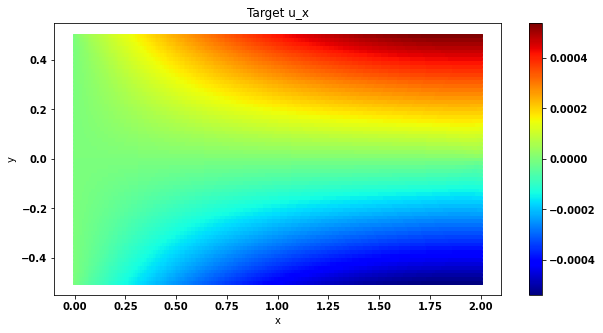

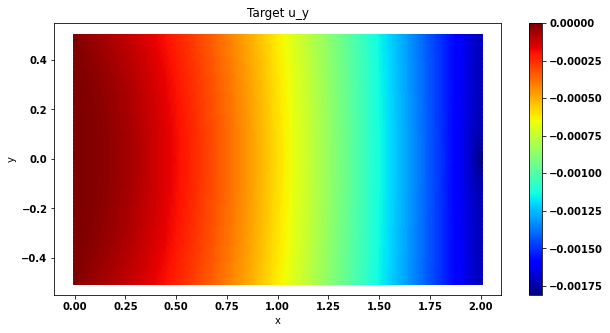

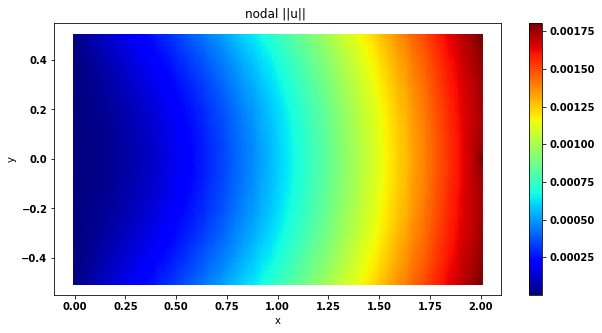

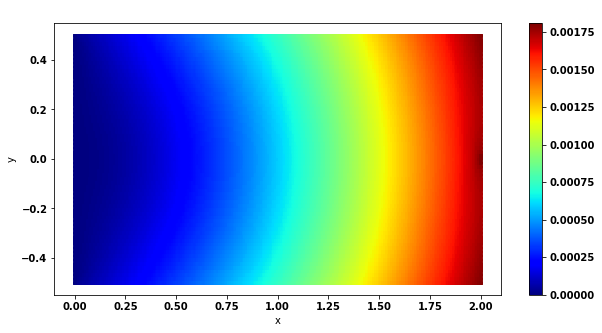

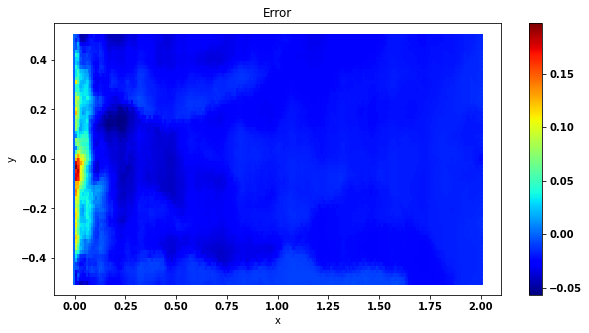

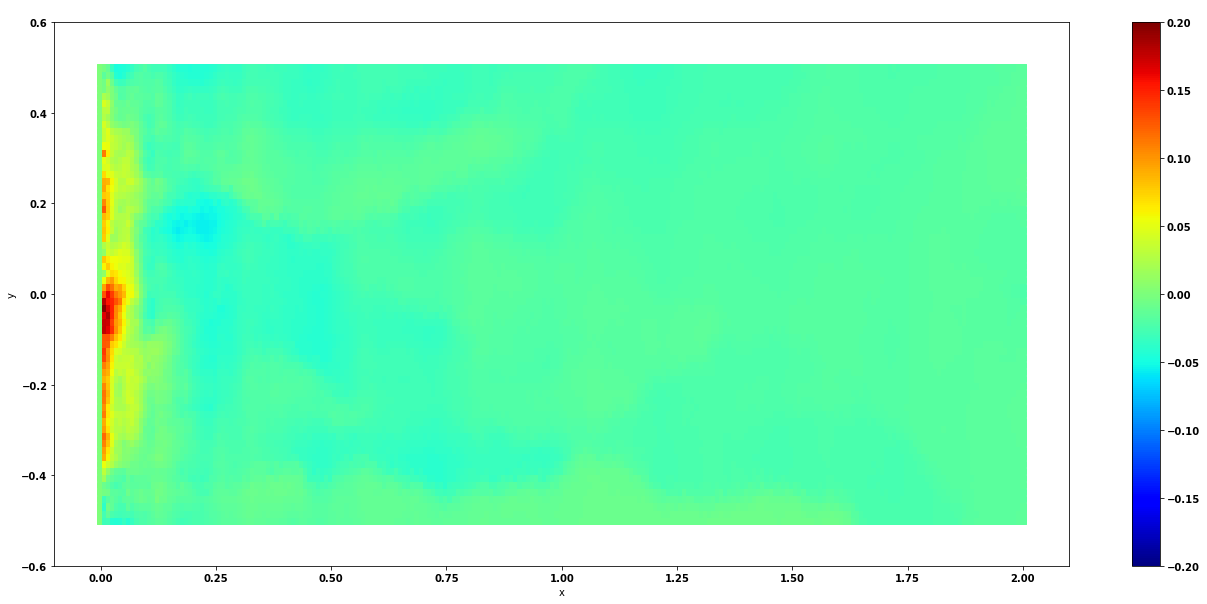

In [ ]:
x,y = np.asarray(raw_tst[father_idx][0].coords).T
z = np.asarray(err_tst_edges)
plot_nodal_vect(x, y, get_node_trajectories(target_nodes,1, 0, 1)[0], "Target u_x", 10)
plot_nodal_vect(x, y, get_node_trajectories(target_nodes,1, 1, 2)[0], "Target u_y", 10)
plot_nodal_vect(x, y, (ml_nodes[..., 0]**2 + 
                ml_nodes[..., 1]**2)**0.5, "nodal ||u|| ", 10)
plot_nodal_vect(x, y, (get_node_trajectories(target_nodes,1, 0, 1)[0]**2 + 
                get_node_trajectories(target_nodes,1, 1, 2)[0]**2)**0.5, " ", 10)
plot_nodal_vect(x, y, z, "Error", 10)
cap = .2
plot_capped_nodal_vect(x, y, z, " ",  40, -cap, cap)

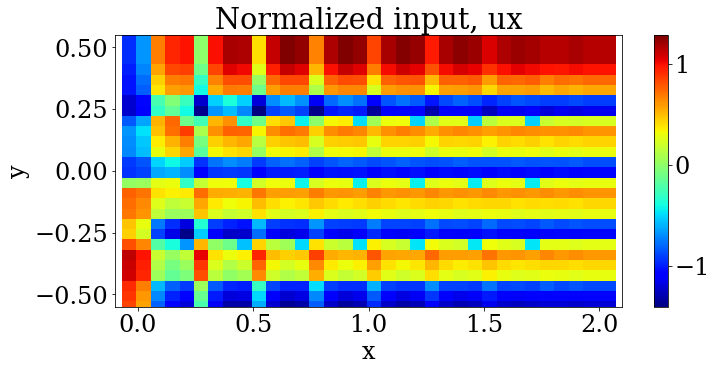

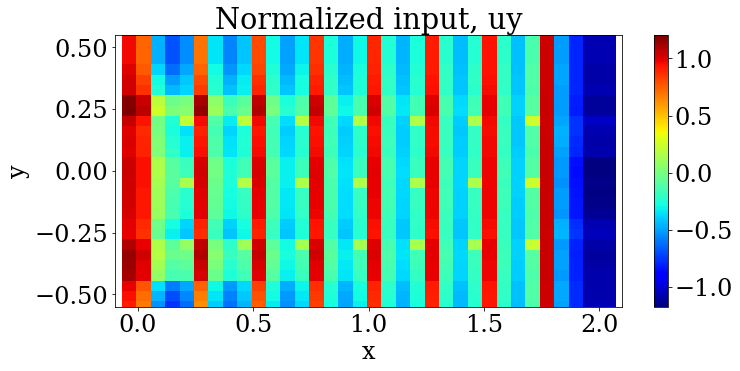

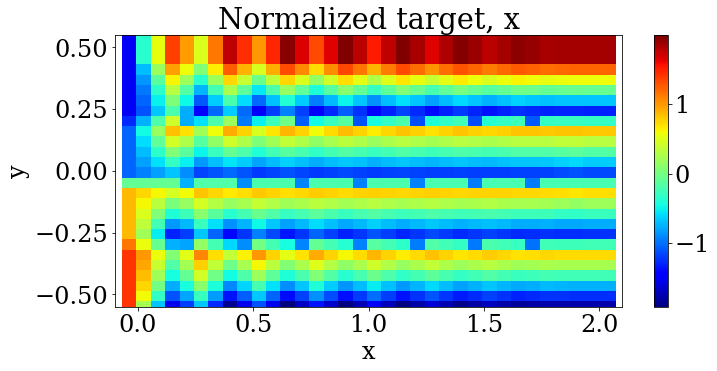

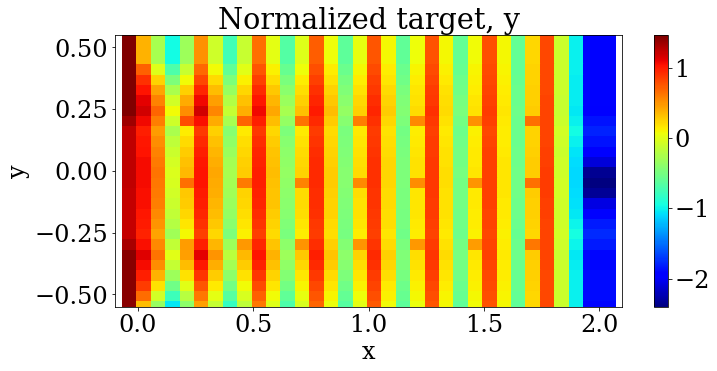

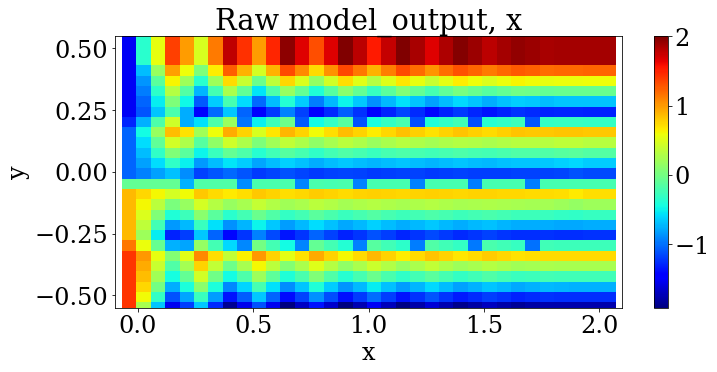

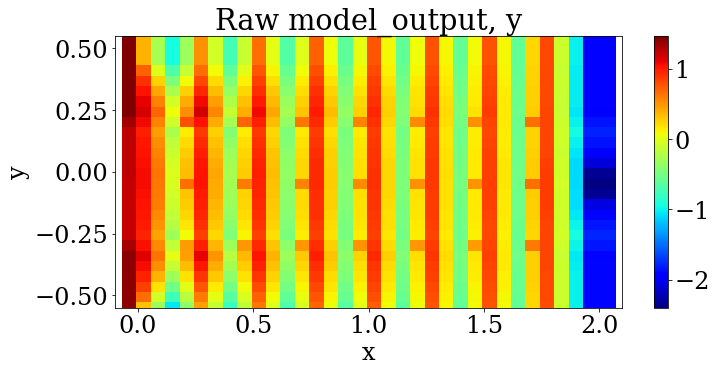

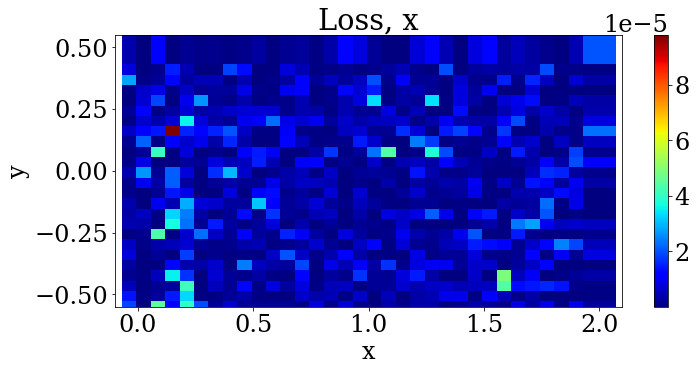

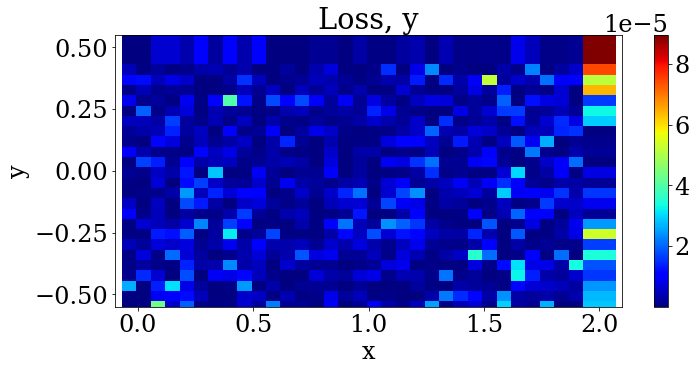

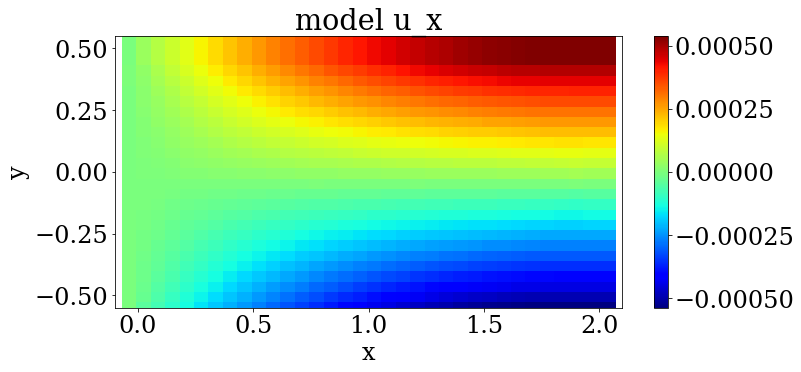

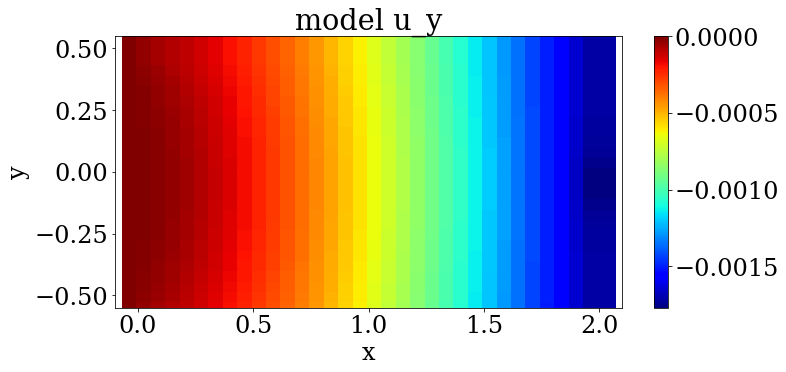

In [ ]:
in_x = get_node_trajectories(input_nodes,1, 0, 1)[0]
in_y = get_node_trajectories(input_nodes,1, 1, 2)[0]
in_ux = get_node_trajectories(input_nodes,1, 5, 6)[0]
in_uy = get_node_trajectories(input_nodes,1, 6, 7)[0]
# plot_nodal_vect(x, y, in_x, "Normalized input, x")
# plot_nodal_vect(x, y, in_y, "Normalized input, y")
plot_nodal_vect(x, y, in_ux, "Normalized input, ux")
plot_nodal_vect(x, y, in_uy, "Normalized input, uy")

tar_x = get_node_trajectories(loss_nodes,1, 0, 1)[0]
tar_y = get_node_trajectories(loss_nodes,1, 1, 2)[0]
loss_x = get_node_trajectories(loss_nodes,1, 2, 3)[0]
loss_y = get_node_trajectories(loss_nodes,1, 3, 4)[0]
raw_x = get_node_trajectories(raw_nodes,1, 0, 1)[0]
raw_y = get_node_trajectories(raw_nodes,1, 1, 2)[0]

plot_nodal_vect(x, y, tar_x, "Normalized target, x")
plot_nodal_vect(x, y, tar_y, "Normalized target, y")
plot_nodal_vect(x, y, raw_x, "Raw model_output, x")
plot_nodal_vect(x, y, raw_y, "Raw model_output, y")
plot_nodal_vect(x, y, loss_x, "Loss, x")
plot_nodal_vect(x, y, loss_y, "Loss, y")
plot_nodal_vect(x, y, ml_nodes[..., 0:1], "model u_x")
plot_nodal_vect(x, y, ml_nodes[..., 1:2], "model u_y")

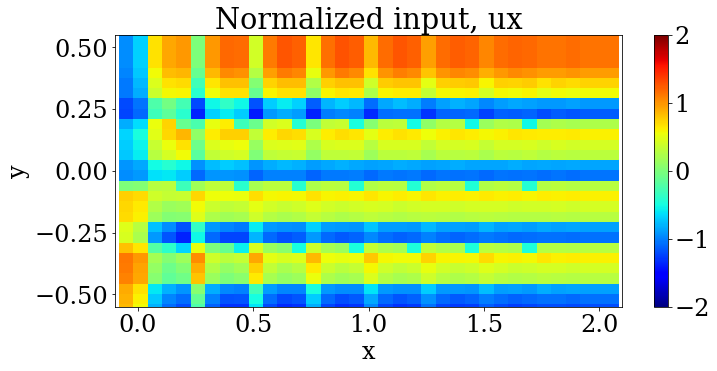

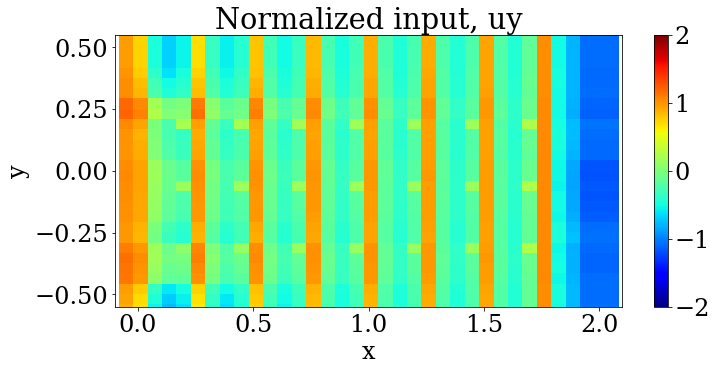

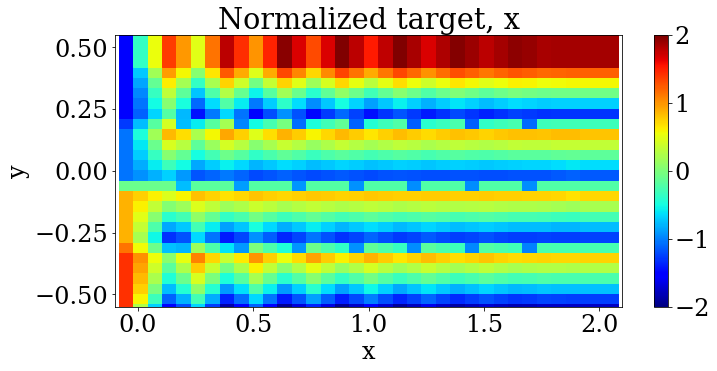

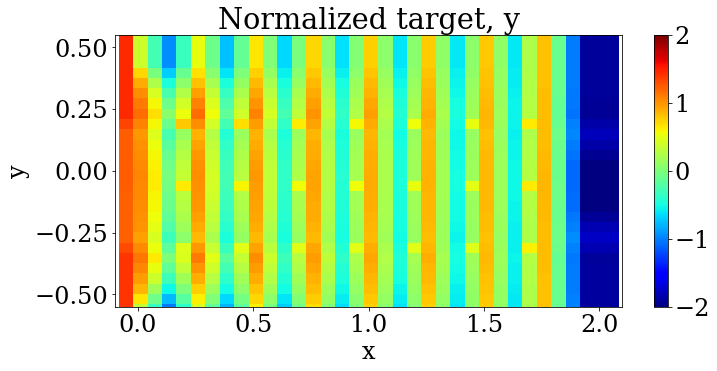

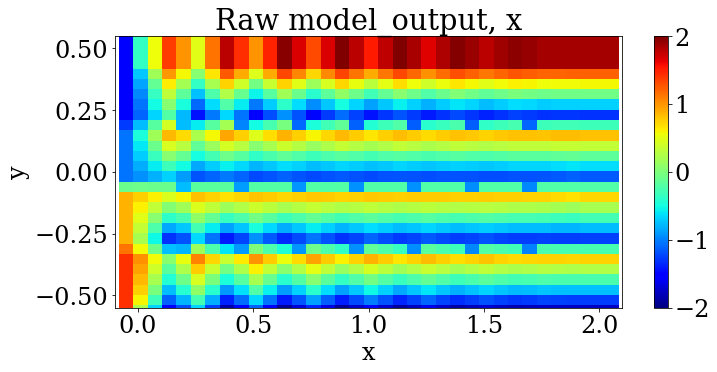

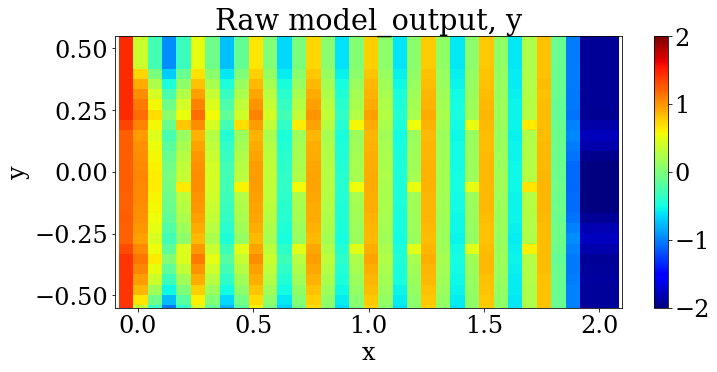

In [ ]:
cap = 2
plot_capped_nodal_vect(x, y, in_ux, "Normalized input, ux", cap)
plot_capped_nodal_vect(x, y, in_uy, "Normalized input, uy", cap)
plot_capped_nodal_vect(x, y, tar_x, "Normalized target, x", cap)
plot_capped_nodal_vect(x, y, tar_y, "Normalized target, y", cap)
plot_capped_nodal_vect(x, y, raw_x, "Raw model_output, x", cap)
plot_capped_nodal_vect(x, y, raw_y, "Raw model_output, y", cap)

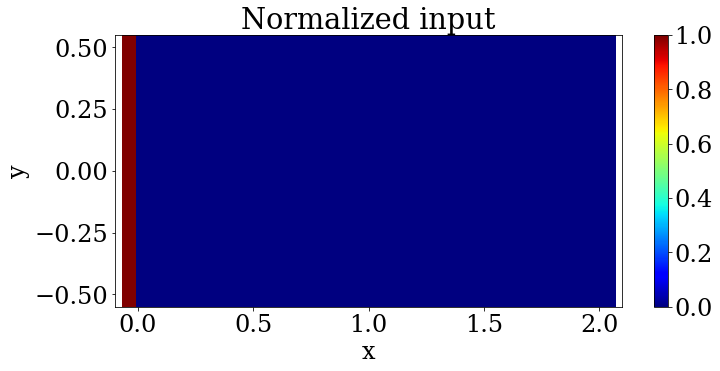

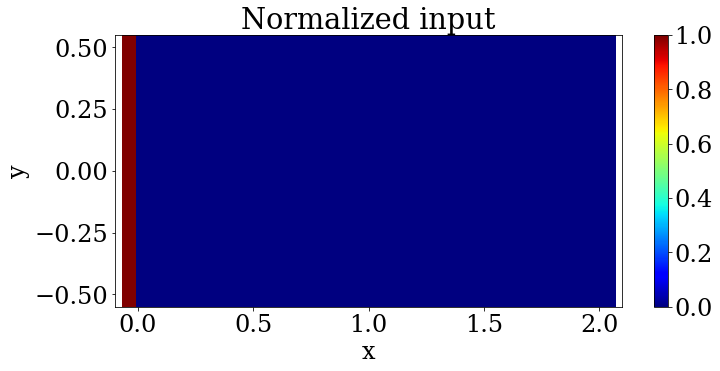

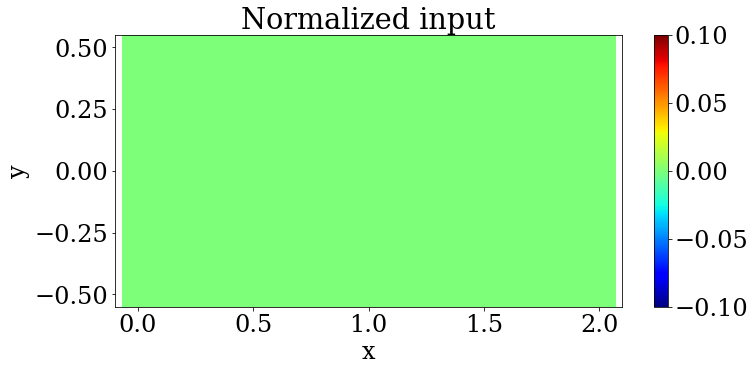

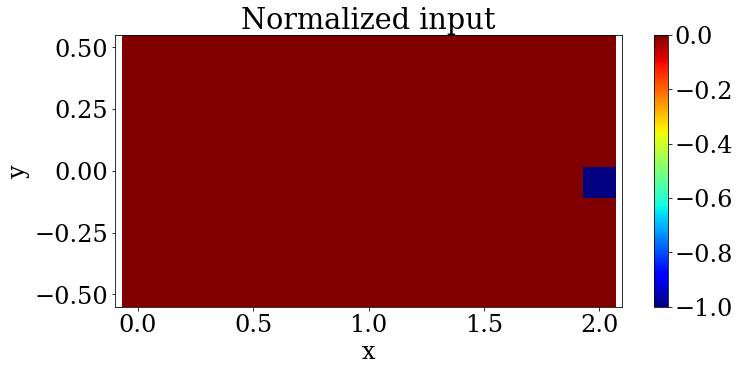

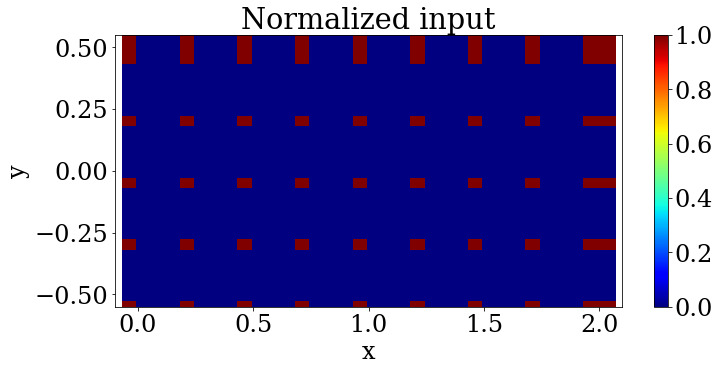

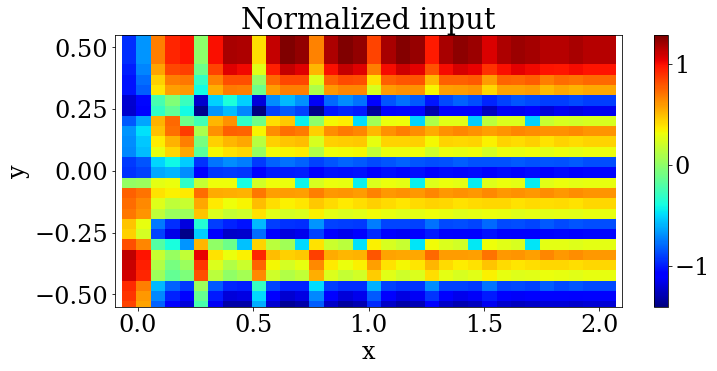

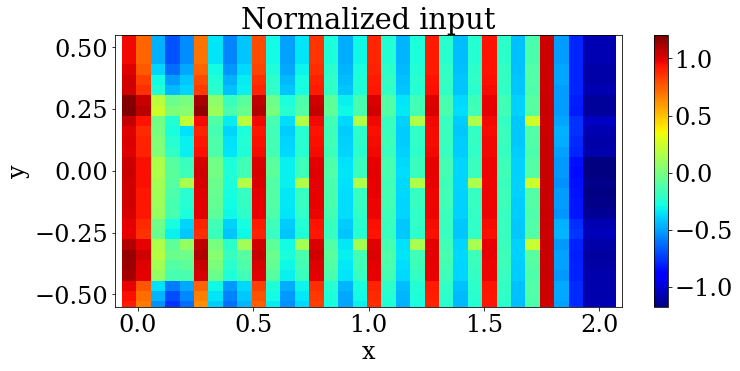

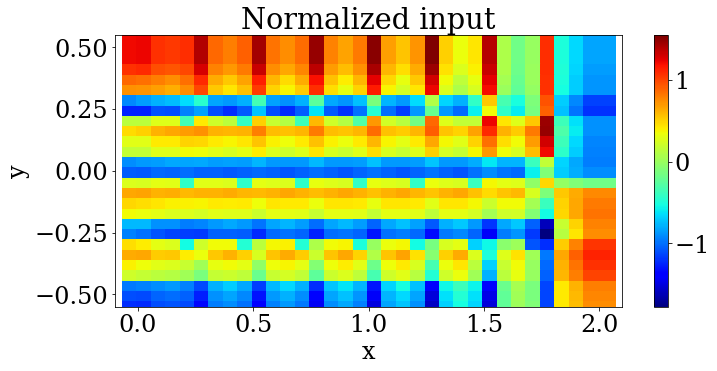

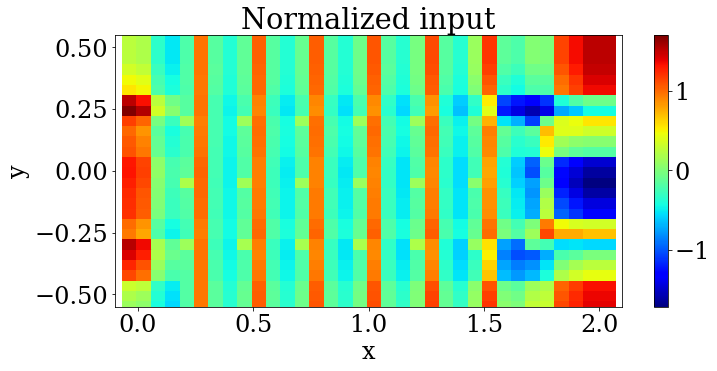

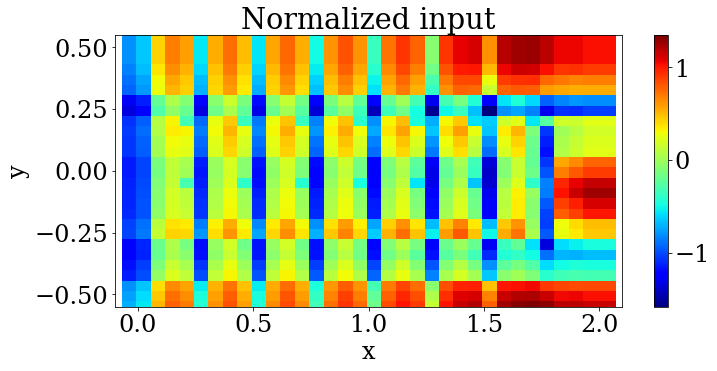

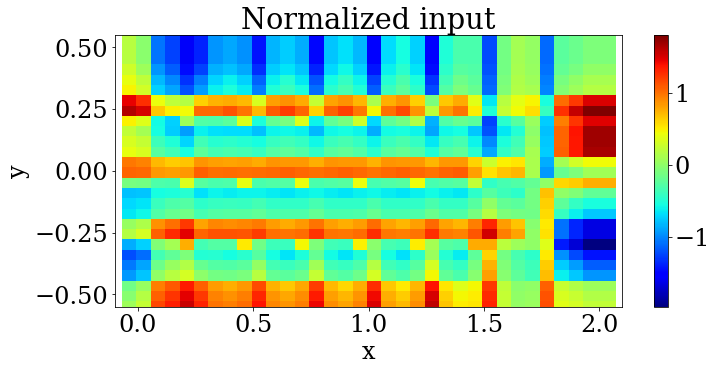

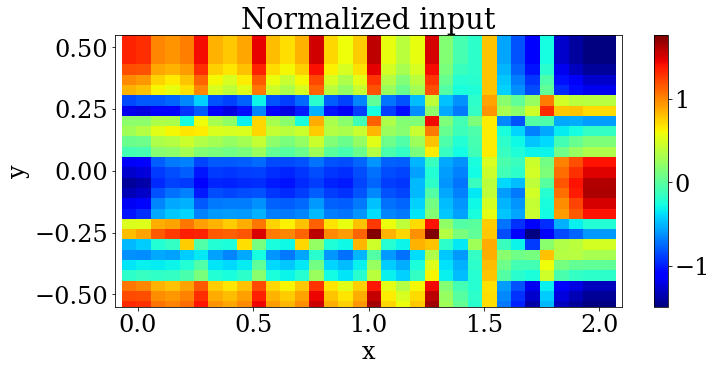

In [ ]:
for i in range(12) :
  in_ux = get_node_trajectories(input_nodes,1, i, i+1)[0]
  plot_nodal_vect(x, y, in_ux, "Normalized input")

# Convergence Study

In [ ]:
# LOAD A HIGH-FI EXAMPLE
with open('{}/Documents_Records/uur_known_240x120'.format(DIRECTORY), 'rb') as f :
  uur_known = dill.load(f)
m1_a = 240
m2_a = 120
m1_list = [24, 40, 48,  80, 120]
m2_list = [int(val/2) for val in m1_list]
m1p_list = [12, 20, 24, 16, 24]
m2p_list = [int(val/2) for val in m1p_list]
M1_list = [8, 10, 12, 8, 8]
M2_list = [int(val/2) for val in M1_list]

father_elems = [a*b for a,b in zip(M1_list, M2_list) ]
father_idxs = [0] + father_elems
for i in range(1,len(father_idxs)) :
  father_idxs[i] = (father_idxs[i-1] + father_idxs[i])

In [ ]:
elem_type = "quad" # "tri" or "quad"
bound_x = (0.0, 2.0)
bound_y = (-0.5, 0.5)
E = 200e9
v = 0.3

force_dofs = [0, 1]
force_vals = [0, -1e7]
body_force = [0.0, 0.0]
vol_frac_min_max = (1.0, 1.0)
density_min_max = (1.0, 1.0)
support_options = ["left_cantilever"] # ["left_cantilever", "right_cantilever", "dual_cantilever", "MBB"]
force_options = ["side_center"] # ["side_center", "side_bottom", "side_top", "top_center", "top_distributed"]
multi_fidelity_opt, KUR_opt, random_bound_opt, random_force_opt = True, False, False, False
force_scale = (-1.0, 1.0)

batch_size_con = 1
refine_fact_con = (0.0, 0.0) 
coord_noise_min_max_con = (0.0, 0.0)
noise_type_con = "posi" 
multiscale_min_max_m1 = (4, 7) # must be at least 4
multiscale_min_max_m2 = (4, 7) # must be at least 4

start_time = time.time()
raw_con, input_graph_list_con, simulated_graph_list_con, graph_recovery_con = generate_convergence_data(
     M1_list, M2_list, m1p_list, m2p_list, m1_list, m2_list, refine_fact_con, vol_frac_min_max, density_min_max, noise_type_con, coord_noise_min_max_con,
    support_options, force_options, multi_fidelity_opt, KUR_opt, random_bound_opt, random_force_opt,
     elem_type, bound_x, bound_y, E, v, force_vals, force_dofs, body_force,
     multiscale_min_max_m1, multiscale_min_max_m2, force_scale)  
initial_conditions_con, true_deformation_con = generate_raw_data(input_graph_list_con, simulated_graph_list_con ,
                                                                              batch_size_con + 1)

input_graph_con = sess.run(initial_conditions_con)
target_con = sess.run(true_deformation_con)
input_graph_con, local_means_con, local_stds_con, local_edge_means_con, local_edge_stds_con = normalize_input_list_informed_multiscale(input_graph_con, input_stats)
input_graph_con = trim_input_informed_multiscale(input_graph_con)
net_time = time.time() - start_time
print("{} Training data ready in {}m {}s".format(len(input_graph_list_con), int(net_time//60), int(net_time % 60)))

output_ops_con = model(initial_conditions_ph)





Stat mesh: 8 x 4 || Father mesh: 12 x 6 || Child mesh: 24 x 12 || Force Vals: 0.0000, -10000000.0000 || left_cantilever, side_center || (0.0, 2.0) x (-0.5, 0.5)
Projection Error: avg 0.0784, max 0.8672, min -0.2812
Pass:  0.0005365314179774032

Stat mesh: 10 x 5 || Father mesh: 20 x 10 || Child mesh: 40 x 20 || Force Vals: 0.0000, -10000000.0000 || left_cantilever, side_center || (0.0, 2.0) x (-0.5, 0.5)
Projection Error: avg 0.0527, max 0.8586, min -0.2808
Pass:  0.0005379554571809206

Stat mesh: 12 x 6 || Father mesh: 24 x 12 || Child mesh: 48 x 24 || Force Vals: 0.0000, -10000000.0000 || left_cantilever, side_center || (0.0, 2.0) x (-0.5, 0.5)
Projection Error: avg 0.0454, max 0.8485, min -0.2814
Pass:  0.0005382202071198404

Stat mesh: 8 x 4 || Father mesh: 16 x 8 || Child mesh: 80 x 40 || Force Vals: 0.0000, -10000000.0000 || left_cantilever, side_center || (0.0, 2.0) x (-0.5, 0.5)
Projection Error: avg 0.0746, max 4.8559, min -0.4096
Pass:  0.0005386999542381084

Stat mesh: 8 x 

## via L2 Norm

In [ ]:
start_time = time.time()
graph_recovery_tst = graph_recovery_con
local_means_tst = local_means_con
local_stds_tst = local_stds_con
input_graph_tst = input_graph_con
target_tst = target_con
local_edge_means_tst = local_edge_means_con
local_edge_stds_tst = local_edge_stds_con

fea_uur = []
ml_uur_nodes = []
ml_uur_edges = []
logged_elems = []
logged_L2_fea = []
logged_L2_ml = []
uur_lengths = []
logged_uur = []
logged_err_avg_fea = []
logged_err_max_fea = []
logged_err_min_fea = []
logged_err_avg_ml = []
logged_err_max_ml = []
logged_err_min_ml = []
father_idx = 0
data_size_con = len(m1_list)
execution_time = 0
for idx_con in range(0, data_size_con):

  fea_sub_graph_list = graph_recovery_tst[father_idx][0]
  graph_nodes = graph_recovery_tst[father_idx][1]
  graph_edges = graph_recovery_tst[father_idx][2]
  
  loss_sub_graph_list = copy.deepcopy(fea_sub_graph_list)
  model_sub_graph_list = []
  input_sub_graph_list = []
  target_sub_graph_list = []
  for i in range(len(fea_sub_graph_list)) :
    data_idx = i + father_idxs[idx_con]

    start_time = time.time()
    feed_dict_2_ge = create_feed_dict(data_idx, input_graph_tst, target_tst, local_means_tst, local_stds_tst, local_edge_means_tst, local_edge_stds_tst,
                                initial_conditions_ph, true_deformation_ph, local_means_ph, local_stds_ph, local_edge_means_ph, local_edge_stds_ph)
    test_values = sess.run({
          "inputs" : initial_conditions_ph,
          "target": true_deformation_ph,
          "loss": loss_op_2_ge,
          "outputs": output_ops_2_ge
          }, feed_dict = feed_dict_2_ge)
    net_time = time.time() - start_time
    execution_time+= net_time

    output_ops = test_values["outputs"]
    target_op = target_tst[data_idx]
    x_norm = (target_op.nodes[..., 0:1] - local_means_tst[data_idx][0]) /  local_stds_tst[data_idx][0]
    y_norm = (target_op.nodes[..., 1:2] - local_means_tst[data_idx][1]) / local_stds_tst[data_idx][1]
    SE_x = ((output_ops[0][..., 0:1] - x_norm)**2)
    SE_y = ((output_ops[0][..., 1:2] - y_norm)**2)
    loss_sub_graph_list[i]["nodes"] = np.concatenate([x_norm, y_norm, SE_x, SE_y], axis = 1)

    input_sub_graph_list.append(test_values["inputs"])
    target_sub_graph_list.append(test_values["target"])
    model_sub_graph_list.append(test_values["outputs"])
  
   
  target_nodes, target_edges = recover_system_nodes_edges(
      "target", fea_sub_graph_list, graph_nodes, graph_edges, local_means_tst[father_idxs[idx_con]: father_idxs[idx_con+1]], local_stds_tst[father_idxs[idx_con]: father_idxs[idx_con+1]], 
                                                                  local_edge_means_tst[father_idxs[idx_con]: father_idxs[idx_con+1]], local_edge_stds_tst[father_idxs[idx_con]: father_idxs[idx_con+1]])
  target_receivers, target_senders = return_senders_receivers(fea_sub_graph_list, graph_nodes, graph_edges)
  input_nodes, input_edges = recover_system_nodes_edges("input", input_sub_graph_list, graph_nodes, graph_edges, 
                                                                  local_means_tst[father_idxs[idx_con]: father_idxs[idx_con+1]], local_stds_tst[father_idxs[idx_con]: father_idxs[idx_con+1]], 
                                                                  local_edge_means_tst[father_idxs[idx_con]: father_idxs[idx_con+1]], local_edge_stds_tst[father_idxs[idx_con]: father_idxs[idx_con+1]])
  model_nodes, model_edges = recover_system_nodes_edges("model", model_sub_graph_list, graph_nodes, graph_edges, 
                                                                  local_means_tst[father_idxs[idx_con]: father_idxs[idx_con+1]], local_stds_tst[father_idxs[idx_con]: father_idxs[idx_con+1]], 
                                                                  local_edge_means_tst[father_idxs[idx_con]: father_idxs[idx_con+1]], local_edge_stds_tst[father_idxs[idx_con]: father_idxs[idx_con+1]])
  input_gt = graphs.GraphsTuple(nodes=input_nodes,
            edges=input_edges,
            globals=[],
            receivers=list([int(val) for val in target_receivers]),
            senders=list([int(val) for val in target_senders]),
            n_node=[],
            n_edge=[])
  
  fea_uur_nodes = get_node_trajectories(target_nodes,1, 0, 2)[0]
  ml_edges = uur_from_edges(input_gt, (model_nodes, model_edges[..., 0:2]),  [[0]*2, [1]*2]*2)
  ml_nodes = get_node_trajectories(model_nodes,1, 0, 2)[0]

  fea_uur.append(fea_uur_nodes)
  ml_uur_nodes.append(ml_nodes)
  ml_uur_edges.append(ml_edges)
  father_idx += 1


  ################################################################################################
  m1 = m1_list[idx_con]
  m2 = m2_list[idx_con]
  uur_b = project_known_displacement(m1_a, m2_a, m1, m2, uur_known)

  disp_b = (uur_b[..., 0]**2 + uur_b[..., 1]**2)**0.5
  disp_fea = (fea_uur_nodes[..., 0]**2 + fea_uur_nodes[..., 1]**2)**0.5
  disp_ml = (ml_edges[..., 0]**2 + ml_edges[..., 1]**2)**0.5
  with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    err_tst_fea = np.nan_to_num(np.abs(disp_b - disp_fea) / disp_b, posinf = 0, neginf =0)
    err_tst_ml = np.nan_to_num(np.abs(disp_b - disp_ml) / disp_b, posinf = 0, neginf =0)
  avg_err_fea = sum(err_tst_fea) / len(err_tst_fea)
  max_fea = err_tst_fea.max()
  min_fea = err_tst_fea.min()
  print("FEA Relative Error: avg {:.5f}, max {:.5f}, min {:.4f}".format(avg_err_fea, max_fea, min_fea))

  avg_err_ml = sum(err_tst_ml) / len(err_tst_ml)
  max_ml = err_tst_ml.max()
  min_ml = err_tst_ml.min()
  print("ML Relative Error: avg {:.5f}, max {:.5f}, min {:.4f}".format(avg_err_ml, max_ml, min_ml))

  L2_fea = np.linalg.norm(uur_b - fea_uur_nodes)
  L2_ml = np.linalg.norm(uur_b - ml_nodes)

  logged_L2_fea.append(L2_fea)
  logged_L2_ml.append(L2_ml)
  logged_err_avg_fea.append(avg_err_fea)
  logged_err_max_fea.append(max_fea)
  logged_err_min_fea.append(min_fea)
  logged_err_avg_ml.append(avg_err_ml)
  logged_err_max_ml.append(max_ml)
  logged_err_min_ml.append(min_ml)
  logged_elems.append(m1*m2)
  uur_lengths.append((m1+1)*(m2+1))
  print(idx_con,':', m1, 'x', m2, end = ' | ')
  print("FEA: {:.4e}".format(L2_fea), end = " | ")
  print("ML: {:.4e}".format(L2_ml), '\n')

print("Model Execution Time in {}m {}s".format(int(execution_time//60), (execution_time % 60)))


FEA Relative Error: avg 0.01280, max 0.07442, min 0.0000
ML Relative Error: avg 0.09110, max 0.88116, min 0.0000
0 : 24 x 12 | FEA: 1.5386e-04 | ML: 6.0794e-04 

FEA Relative Error: avg 0.00607, max 0.06680, min 0.0000
ML Relative Error: avg 0.06222, max 0.69961, min 0.0000
1 : 40 x 20 | FEA: 1.0862e-04 | ML: 3.7400e-04 

FEA Relative Error: avg 0.00460, max 0.06460, min 0.0000
ML Relative Error: avg 0.08047, max 0.88075, min 0.0000
2 : 48 x 24 | FEA: 9.5698e-05 | ML: 3.0757e-04 

FEA Relative Error: avg 0.00198, max 0.05692, min 0.0000
ML Relative Error: avg 0.11992, max 2.63240, min 0.0000
3 : 80 x 40 | FEA: 6.4481e-05 | ML: 9.3007e-04 

FEA Relative Error: avg 0.00089, max 0.04578, min 0.0000
ML Relative Error: avg 0.04559, max 3.13887, min 0.0000
4 : 120 x 60 | FEA: 4.1870e-05 | ML: 1.2061e-03 

Model Execution Time in 0m 8.318055868148804s


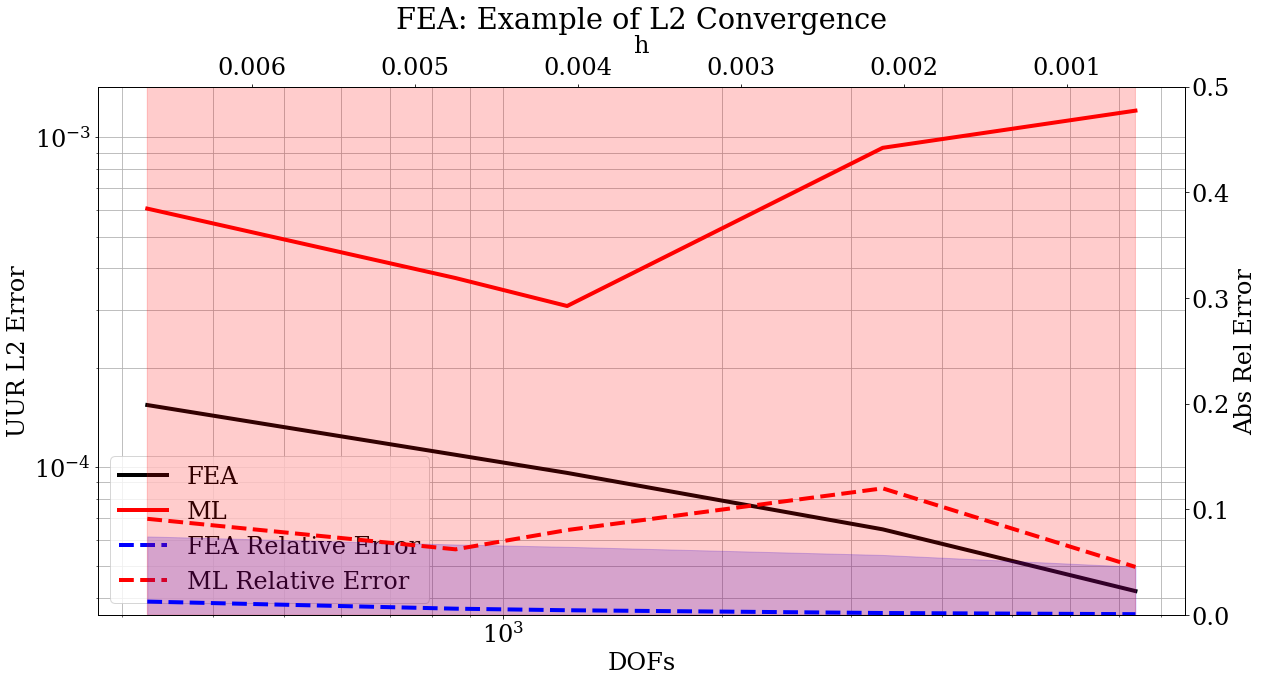

-0.41232564903859714
r^2 = 0.476


In [ ]:
o = 0
i = 10
h = 2/np.asarray(logged_elems)[o:i]
x = np.asarray(uur_lengths)[o:i]
y0 = np.asarray(logged_L2_fea)[o:i]
y1 = np.asarray(logged_L2_ml)[o:i]
avg_e_fea = np.asarray(logged_err_avg_fea)[o:i]
max_e_fea = np.asarray(logged_err_max_fea)[o:i]
min_e_fea = np.asarray(logged_err_min_fea)[o:i]
avg_e_ml = np.asarray(logged_err_avg_ml)[o:i]
max_e_ml = np.asarray(logged_err_max_ml)[o:i]
min_e_ml = np.asarray(logged_err_min_ml)[o:i]

################################################################
error_lim = 0.5
fea_err_color = "blue"
ml_err_color = "red"

fig = plt.figure(1, figsize=(50, 10))
font = {'family' : 'Verdana',
        'weight' : 'normal',
        'size'   : 24}
from matplotlib import rcParams
mpl.rc('font', **font)
lw = 4
rcParams['font.family'] = 'serif'
rcParams['font.sans-serif'] = ['Tahoma']

# Convergence
ax = fig.add_subplot(1, 3, 1)
ax.grid(True, which = 'both')
ax.set_title("FEA: Example of L2 Convergence") 
ax.set_ylabel('UUR L2 Error')
ax.set_xlabel('DOFs')
plt.xscale("log")
plt.yscale("log")
line1 = ax.plot(x, y0, c = 'k', lw = lw, label = 'FEA', zorder = 10)
line2 = ax.plot(x, y1, c = 'r', lw = lw, label = 'ML', zorder = 10)
# Relative Error
ax1 = ax.twinx()
ax1.set_ylim([0, error_lim])
ax1.set_ylabel('Abs Rel Error')
line3 = ax1.plot(x, avg_e_fea, '--', c = fea_err_color, lw = lw, label = 'FEA Relative Error')
line4 = ax1.plot(x, avg_e_ml, '--', c = ml_err_color, lw = lw, label = 'ML Relative Error')
line5 = ax1.fill_between(x, min_e_fea, max_e_fea, color = fea_err_color, alpha = 0.2, label = "FEA Error Bounds")
line6 = ax1.fill_between(x, min_e_ml, max_e_ml, color = ml_err_color, alpha = 0.2, label = "ML Error Bounds")
# secax = ax.secondary_xaxis('top', 2/np.asarray(logged_elems)[o:i])
# secax.set_xlabel('angle [rad]')


# DOF
ax2 = ax.twiny()
ax2.set_xlabel('h')
ax2.set_xlim([h.max(), h.min()])

# Legend
lns = line1 + line2 + line3 + line4
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=0)
fig.tight_layout()
plt.show()

# Polyfit
m, b = np.polyfit(np.log10(x), np.log10(y0), 1)
print(m)


slope, intercept, r_value, p_value, std_err = stats.linregress(np.log10(y0), np.log10(y1))
print("r^2 = {:.3f}".format(r_value**2))

## Error Visualization

FEA Relative Error: avg 0.00198, max 0.05692, min 0.00000
ML Relative Error: avg 0.11992, max 2.63240, min 0.00000


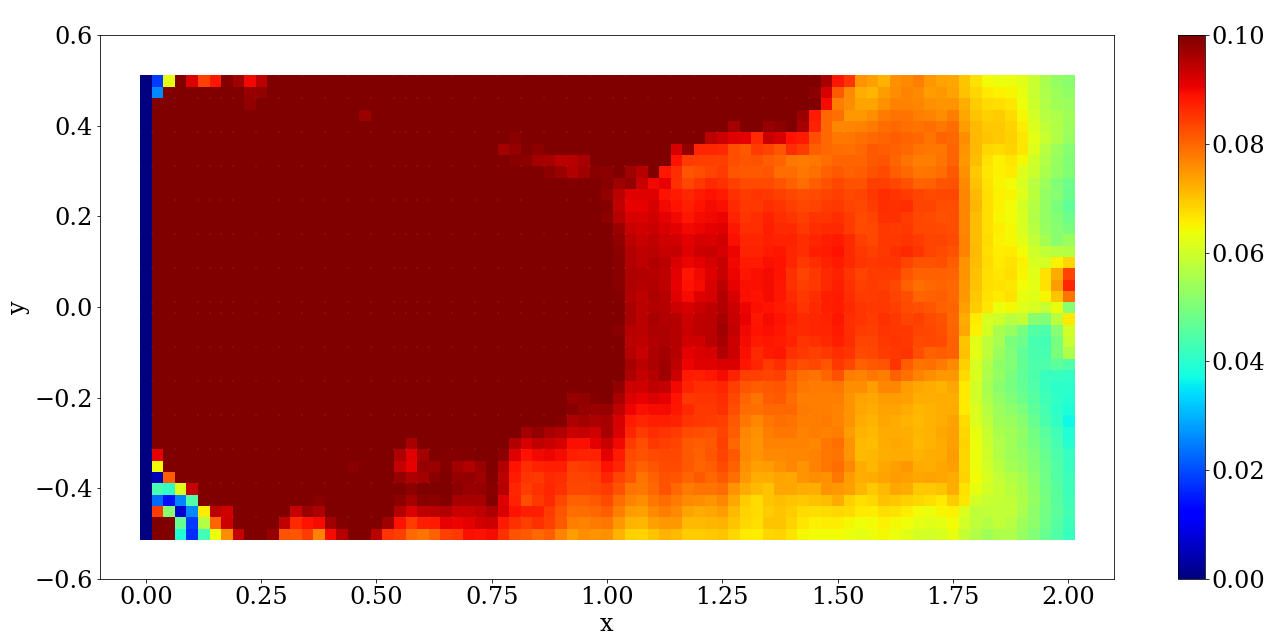

In [ ]:
idx = -2
cap = 0.1
size = 120
use_nodal_uur = False
###########################################################

m1, m2 = m1_list[idx], m2_list[idx]
uur_fea = fea_uur[idx]
if use_nodal_uur :
  uur_ml = ml_uur_nodes[idx]
else :
  uur_ml = ml_uur_edges[idx]

x, y = np.asarray(raw_con[idx][0].coords).T

uur_b = project_known_displacement(m1_a, m2_a, m1, m2, uur_known)
disp_b = (uur_b[..., 0]**2 + uur_b[..., 1]**2)**0.5
disp_fea = (uur_fea[..., 0]**2 + uur_fea[..., 1]**2)**0.5
disp_ml = (uur_ml[..., 0]**2 + uur_ml[..., 1]**2)**0.5
with warnings.catch_warnings():
  warnings.simplefilter("ignore")
  err_tst_fea = np.nan_to_num(np.abs(disp_b - disp_fea) / disp_b, posinf = 0, neginf =0)
  err_tst_ml = np.nan_to_num(np.abs(disp_b - disp_ml) / disp_b, posinf = 0, neginf =0)
avg_err_fea = sum(err_tst_fea) / len(err_tst_fea)
max_fea = err_tst_fea.max()
min_fea = err_tst_fea.min()
print("FEA Relative Error: avg {:.5f}, max {:.5f}, min {:.5f}".format(avg_err_fea, max_fea, min_fea))

avg_err_ml = sum(err_tst_ml) / len(err_tst_ml)
max_ml = err_tst_ml.max()
min_ml = err_tst_ml.min()
print("ML Relative Error: avg {:.5f}, max {:.5f}, min {:.5f}".format(avg_err_ml, max_ml, min_ml))



plot_capped_nodal_vect(x,y,err_tst_ml," ", size, 0, cap)

# Multi BC Study

In [ ]:
def get_colors(inp, colormap =plt.cm.jet,
               color_min = 0, color_max = 0):
    if color_min == 0 :
      vmin = np.min(inp)
    else :
      vmin = color_min
    if color_max == 0 :
      vmax = np.max(inp)
    else :
      vmax = color_max
    norm = plt.Normalize(vmin, vmax)
    return norm, colormap(norm(inp))

def get_elem_avg(mesh, nodal_attr) :
  elem_attr = np.zeros((mesh.n_elem, 1))
  counts = 4*np.ones((mesh.n_elem, 1))
  for elem_i, elem in enumerate(mesh.elem_nodes) :
    elem_attr[elem_i,:] = np.mean([nodal_attr[i] for i in elem])

  return elem_attr

def plot_elem_avg(mesh, elem_attr,
                  plt_cm = plt.cm.jet,
               color_min = 0, color_max = 0) :
  
  # Plot Mesh
  fig = plt.figure(1, figsize=(50, 10))
  ax = fig.add_subplot(1, 2, 1)
  # ax.grid(True, which = 'both')
  ax.set_ylabel('y')
  ax.set_xlabel('x')
  ax.axis('equal')

  #nodes
  x, y = np.asarray(mesh.coords).T
  ax.scatter(x, y, c = 'k', zorder = 10, s=1)

  #elements
  for elem in mesh.elem_nodes :
    elem_coords= [mesh.coords[elem[0]], mesh.coords[elem[1]], 
                          mesh.coords[elem[2]], mesh.coords[elem[3]], mesh.coords[elem[0]]]
    x, y = np.asarray(elem_coords).T
    ax.plot(x, y, 'k', lw=1)


  ################################################################################
  #Plot elem attr condition 
  norm, color_array = get_colors(elem_attr, colormap = plt_cm, 
                              color_min = color_min, color_max = color_max)

  for i, elem in enumerate(mesh.elem_nodes ): 
    elem_coords= [mesh.coords[elem[0]], mesh.coords[elem[1]], 
                          mesh.coords[elem[2]], mesh.coords[elem[3]], mesh.coords[elem[0]]]
    x, y = np.asarray(elem_coords).T
    plt.fill_between(x, y, color = color_array[i])

  cax, _ = mpl.colorbar.make_axes(ax) 
  cb2 = mpl.colorbar.ColorbarBase(cax, cmap=plt_cm, norm=norm,) 
  cb2.formatter.set_powerlimits((0, 0))
  
  plt.show()
  fig.clf()

## L-bracket

In [ ]:
bound_x = (0.0, 2.0)
bound_y = (-0.5, 0.5)


force_dofs = [0, 1]
force_vals = [0, -1e7]
body_force = [0.0, 0.0]
vol_frac_min_max = (1.0, 1.0)
density_min_max = (1.0, 1.0)
support_options = ["L_bracket"] # ["left_cantilever", "right_cantilever", "dual_cantilever", "MBB"]
force_options = ["side_center"] # ["side_center", "side_bottom", "side_top", "top_center", "top_distributed"]
multi_fidelity_opt, KUR_opt, random_bound_opt, random_force_opt = True, False, False, False
force_scale = (-1.0, 1.0)
########################################################################

# Gen params 0.
data_size_gen = 1
batch_size_gen = 1
m1_min_max_gen = (8, 9) 
m2_min_max_gen = (4, 5) 
refine_fact_gen = (0.0, 0.0) 
coord_noise_min_max_gen = (0.0, 0.0)
noise_type_gen = "posi" 

# Test data 0.
multiscale_min_max_m1 = (2, 4) 
multiscale_min_max_m2 = (2, 4) 
m1_list = [48]
m2_list = [int(val/2) for val in m1_list]
m1p_list = [12]
m2p_list = [int(val/2) for val in m1p_list]
M1_list = [12]
M2_list = [int(val/2) for val in M1_list]

raw_gen, input_graph_list_gen, simulated_graph_list_gen, graph_recovery_gen = generate_convergence_data(
     M1_list, M2_list, m1p_list, m2p_list, m1_list, m2_list, refine_fact_gen, vol_frac_min_max, density_min_max, noise_type_gen, coord_noise_min_max_gen,
    support_options, force_options, multi_fidelity_opt, KUR_opt, random_bound_opt, random_force_opt,
     elem_type, bound_x, bound_y, E, v, force_vals, force_dofs, body_force,
     multiscale_min_max_m1, multiscale_min_max_m2, force_scale)  
initial_conditions_gen, true_deformation_gen = generate_raw_data(input_graph_list_gen, simulated_graph_list_gen ,
                                                                              batch_size_gen + 1)

input_graph_gen = sess.run(initial_conditions_gen)
target_gen = sess.run(true_deformation_gen)
input_graph_gen, local_means_gen, local_stds_gen, local_edge_means_gen, local_edge_stds_gen = normalize_input_list_informed_multiscale(input_graph_gen, input_stats)
input_graph_gen = trim_input_informed_multiscale(input_graph_gen)

output_ops_gen = model(initial_conditions_ph)



Stat mesh: 12 x 6 || Father mesh: 12 x 6 || Child mesh: 48 x 24 || Force Vals: 0.0000, -10000000.0000 || L_bracket, side_center || (0.0, 2.0) x (-0.5, 0.5)
Projection Error: avg 0.0633, max 1.3917, min -0.8338
Pass:  0.003800859203668464


In [ ]:
start_time = time.time()
graph_recovery_tst = graph_recovery_gen
local_means_tst = local_means_gen
local_stds_tst = local_stds_gen
input_graph_tst = input_graph_gen
target_tst = target_gen
local_edge_means_tst = local_edge_means_gen
local_edge_stds_tst = local_edge_stds_gen

fea_uur = []
ml_uur_nodes = []
ml_uur_edges = []
logged_elems = []
logged_L2_fea = []
logged_L2_ml = []
uur_lengths = []
logged_uur = []
logged_err_avg_fea = []
logged_err_max_fea = []
logged_err_min_fea = []
logged_err_avg_ml = []
logged_err_max_ml = []
logged_err_min_ml = []
father_idx = 0
father_idxs = [0, 2*12*6]
idx_con = 0

fea_sub_graph_list = graph_recovery_tst[father_idx][0]
graph_nodes = graph_recovery_tst[father_idx][1]
graph_edges = graph_recovery_tst[father_idx][2]

loss_sub_graph_list = copy.deepcopy(fea_sub_graph_list)
model_sub_graph_list = []
input_sub_graph_list = []
target_sub_graph_list = []
for i in range(len(fea_sub_graph_list)) :
  data_idx = i + father_idxs[idx_con]
  feed_dict_2_ge = create_feed_dict(data_idx, input_graph_tst, target_tst, local_means_tst, local_stds_tst, local_edge_means_tst, local_edge_stds_tst,
                              initial_conditions_ph, true_deformation_ph, local_means_ph, local_stds_ph, local_edge_means_ph, local_edge_stds_ph)
  test_values = sess.run({
        "inputs" : initial_conditions_ph,
        "target": true_deformation_ph,
        "loss": loss_op_2_ge,
        "outputs": output_ops_2_ge
        }, feed_dict = feed_dict_2_ge)
  output_ops = test_values["outputs"]
  target_op = target_tst[data_idx]
  x_norm = (target_op.nodes[..., 0:1] - local_means_tst[data_idx][0]) /  local_stds_tst[data_idx][0]
  y_norm = (target_op.nodes[..., 1:2] - local_means_tst[data_idx][1]) / local_stds_tst[data_idx][1]
  SE_x = ((output_ops[0][..., 0:1] - x_norm)**2)
  SE_y = ((output_ops[0][..., 1:2] - y_norm)**2)
  loss_sub_graph_list[i]["nodes"] = np.concatenate([x_norm, y_norm, SE_x, SE_y], axis = 1)

  input_sub_graph_list.append(test_values["inputs"])
  target_sub_graph_list.append(test_values["target"])
  model_sub_graph_list.append(test_values["outputs"])

target_nodes, target_edges = recover_system_nodes_edges(
    "target", fea_sub_graph_list, graph_nodes, graph_edges, local_means_tst[father_idxs[idx_con]: father_idxs[idx_con+1]], local_stds_tst[father_idxs[idx_con]: father_idxs[idx_con+1]], 
                                                                local_edge_means_tst[father_idxs[idx_con]: father_idxs[idx_con+1]], local_edge_stds_tst[father_idxs[idx_con]: father_idxs[idx_con+1]])
target_receivers, target_senders = return_senders_receivers(fea_sub_graph_list, graph_nodes, graph_edges)
input_nodes, input_edges = recover_system_nodes_edges("input", input_sub_graph_list, graph_nodes, graph_edges, 
                                                                local_means_tst[father_idxs[idx_con]: father_idxs[idx_con+1]], local_stds_tst[father_idxs[idx_con]: father_idxs[idx_con+1]], 
                                                                local_edge_means_tst[father_idxs[idx_con]: father_idxs[idx_con+1]], local_edge_stds_tst[father_idxs[idx_con]: father_idxs[idx_con+1]])
model_nodes, model_edges = recover_system_nodes_edges("model", model_sub_graph_list, graph_nodes, graph_edges, 
                                                                local_means_tst[father_idxs[idx_con]: father_idxs[idx_con+1]], local_stds_tst[father_idxs[idx_con]: father_idxs[idx_con+1]], 
                                                                local_edge_means_tst[father_idxs[idx_con]: father_idxs[idx_con+1]], local_edge_stds_tst[father_idxs[idx_con]: father_idxs[idx_con+1]])
projection_nodes, projection_edges = recover_system_nodes_edges("projection", input_sub_graph_list, graph_nodes, graph_edges, 
                                                       local_means_tst[father_idxs[idx_con]: father_idxs[idx_con+1]], local_stds_tst[father_idxs[idx_con]: father_idxs[idx_con+1]], 
                                                                local_edge_means_tst[father_idxs[idx_con]: father_idxs[idx_con+1]], local_edge_stds_tst[father_idxs[idx_con]: father_idxs[idx_con+1]])


input_gt = graphs.GraphsTuple(nodes=input_nodes,
          edges=input_edges,
          globals=[],
          receivers=list([int(val) for val in target_receivers]),
          senders=list([int(val) for val in target_senders]),
          n_node=[],
          n_edge=[])

fea_uur_nodes = get_node_trajectories(target_nodes,1, 0, 2)[0]
ml_edges = uur_from_edges(input_gt, (model_nodes, model_edges[..., 0:2]),  [[0]*2, [1]*2]*2)
ml_nodes = get_node_trajectories(model_nodes,1, 0, 2)[0]



ML Relative Error: avg 0.0458, max 1.0148, min 0.0000
Projection Relative Error: avg 0.0633, max 1.3917, min 0.0000


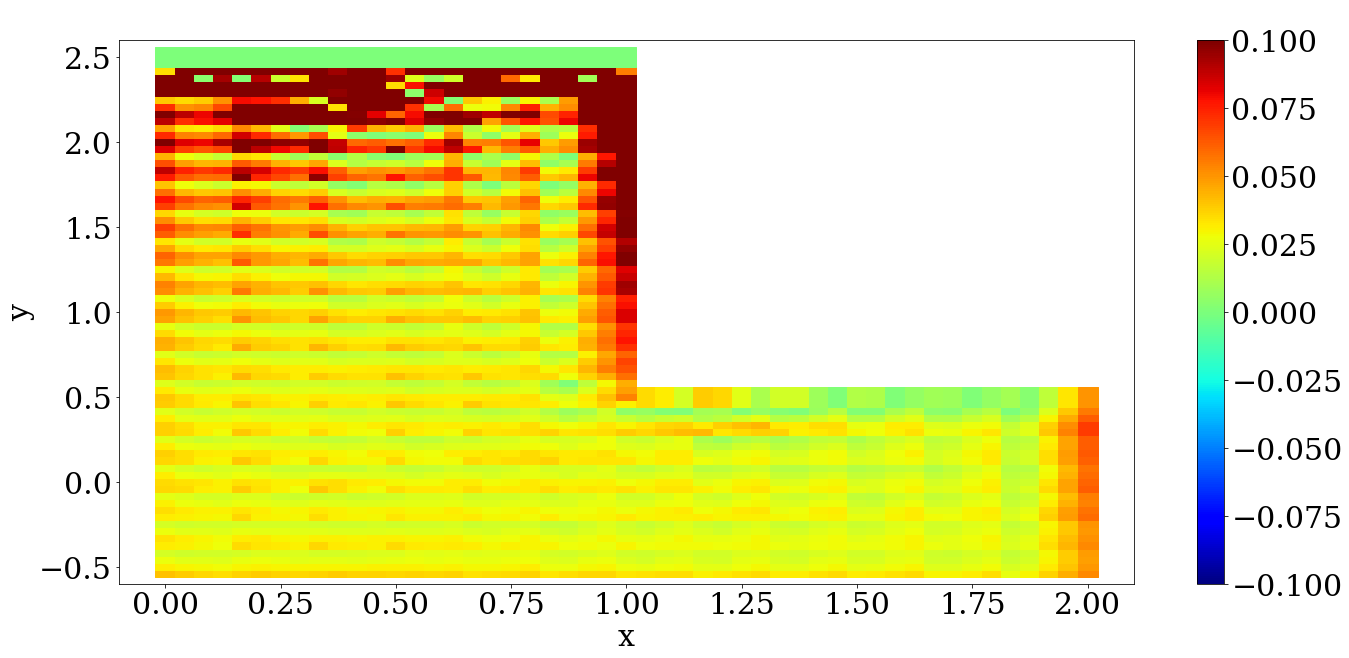

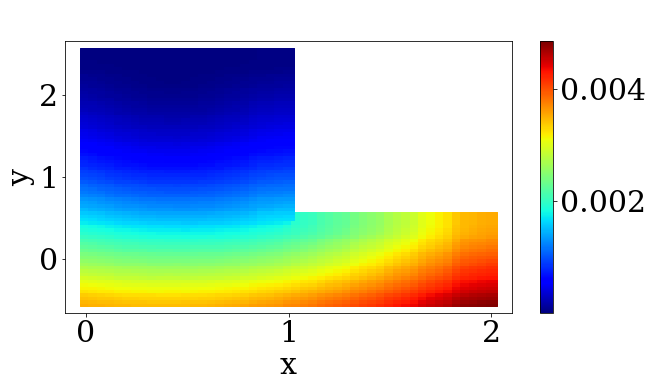

In [ ]:
font = {'family' : 'Verdana',
        'weight' : 'normal',
        'size'   : 30}
from matplotlib import rcParams
mpl.rc('font', **font)
lw = 4
rcParams['font.family'] = 'serif'
rcParams['font.sans-serif'] = ['Tahoma']
cap = 0.1
size = 400
use_nodal_uur = True
###########################################################
idx = 0

m1, m2 = m1_list[idx], m2_list[idx]
uur_fea = fea_uur_nodes
if use_nodal_uur :
  uur_ml = ml_nodes
else :
  uur_ml = ml_edges
x, y = np.asarray(raw_gen[idx][0].coords).T

disp_fea = (uur_fea[..., 0]**2 + uur_fea[..., 1]**2)**0.5
disp_ml = (uur_ml[..., 0]**2 + uur_ml[..., 1]**2)**0.5
disp_proj =  (projection_nodes[..., 0]**2 + projection_nodes[..., 1]**2)**0.5
with warnings.catch_warnings():
  warnings.simplefilter("ignore")
  err_tst_ml = np.nan_to_num(np.abs(disp_fea - disp_ml) / disp_fea, posinf = 0, neginf =0)
  err_proj = np.nan_to_num(np.abs(disp_fea - disp_proj) / disp_fea, posinf = 0, neginf =0)

avg_err_ml = sum(err_tst_ml) / len(err_tst_ml)
max_ml = err_tst_ml.max()
min_ml = err_tst_ml.min()
print("ML Relative Error: avg {:.4f}, max {:.4f}, min {:.4f}".format(avg_err_ml, max_ml, min_ml))

avg_err_proj = sum(err_proj) / len(err_proj)
max_proj = err_proj.max()
min_proj = err_proj.min()
print("Projection Relative Error: avg {:.4f}, max {:.4f}, min {:.4f}".format(avg_err_proj, max_proj, min_proj))


plot_capped_nodal_vect(x,y,err_tst_ml," ", size, -cap, cap)
plot_nodal_vect(x, y, disp_ml, " ", size/3)

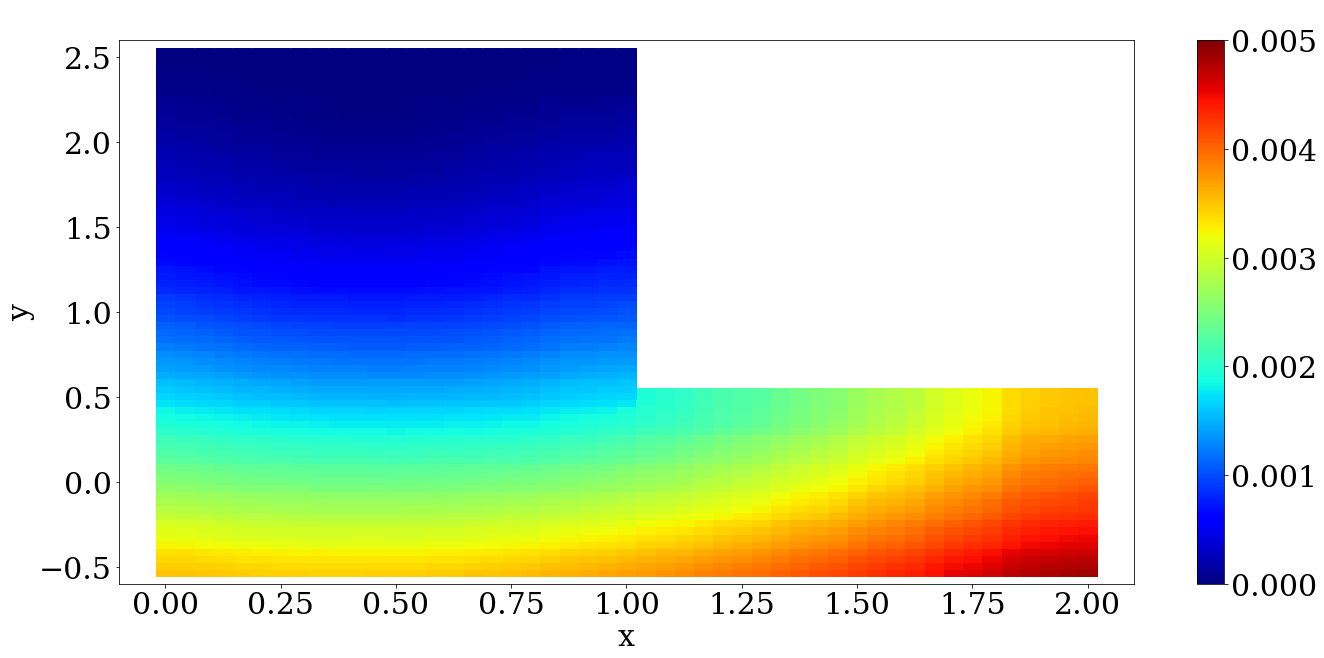

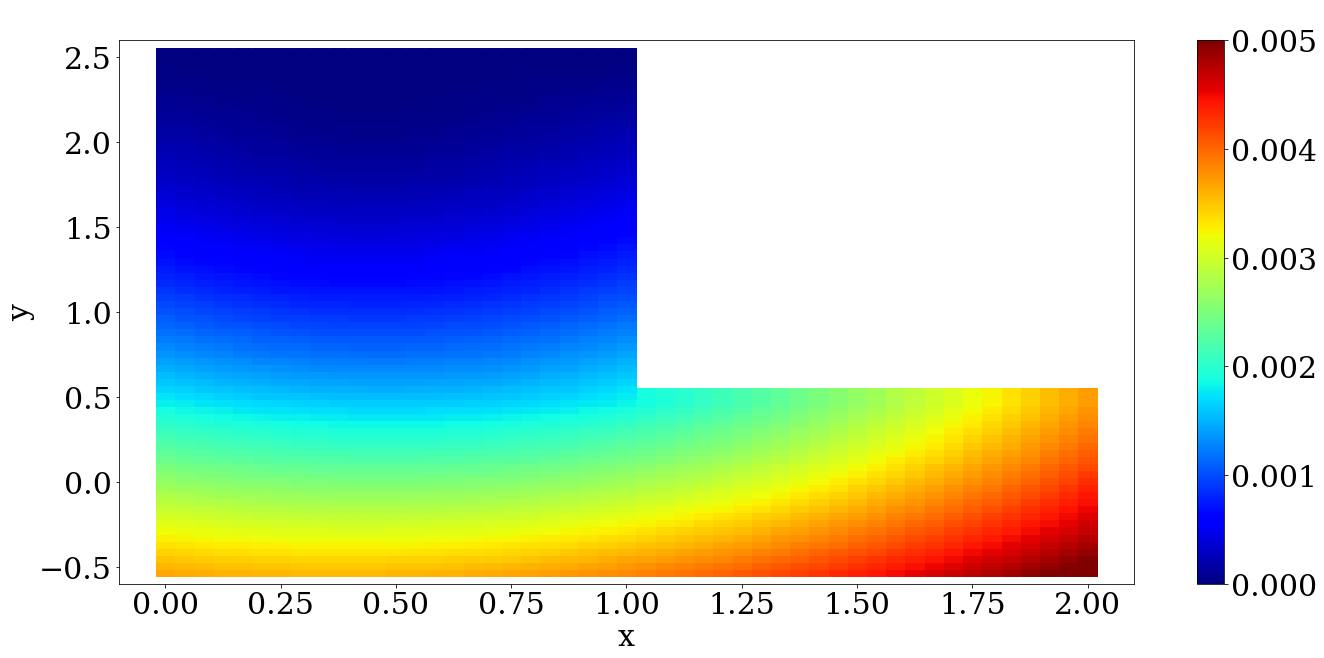

In [ ]:
font = {'family' : 'Verdana',
        'weight' : 'normal',
        'size'   : 30}
from matplotlib import rcParams
mpl.rc('font', **font)
lw = 4
rcParams['font.family'] = 'serif'
rcParams['font.sans-serif'] = ['Tahoma']
plot_capped_nodal_vect(x, y, disp_ml, " ", 340, 0, .005)
plot_capped_nodal_vect(x, y, disp_fea, " ", 340, 0, .005)

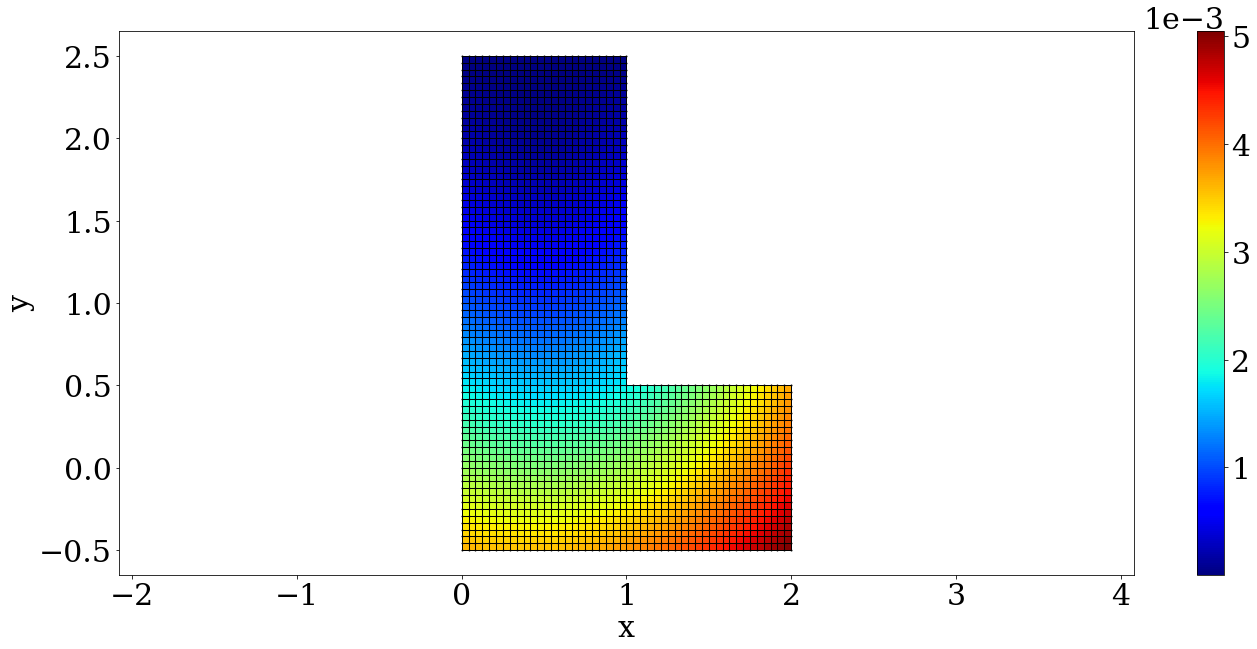

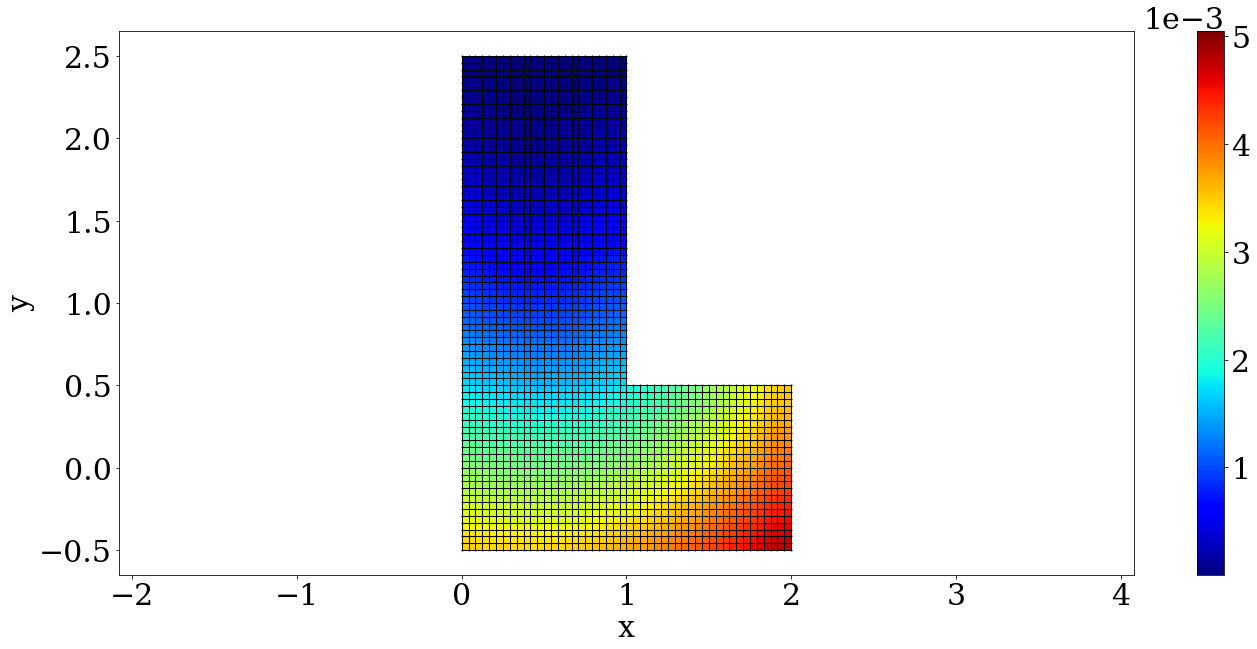

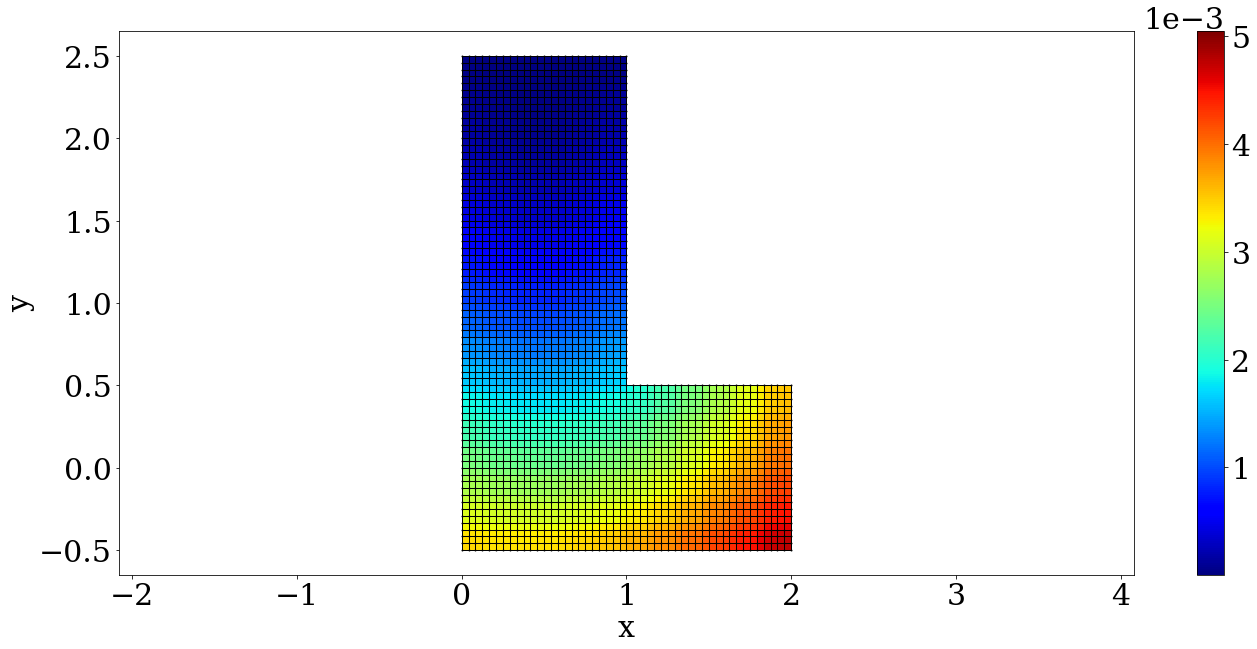

In [ ]:
mesh = raw_gen[0][0]

true_attr = get_elem_avg(mesh, disp_fea)
c_min, c_max = np.amin(true_attr), np.amax(true_attr)
plot_elem_avg(mesh, true_attr) 
plot_elem_avg(mesh, get_elem_avg(mesh, disp_ml),
              color_min = c_min, color_max = c_max) 
plot_elem_avg(mesh, get_elem_avg(mesh, disp_proj),
              color_min = c_min, color_max = c_max)  

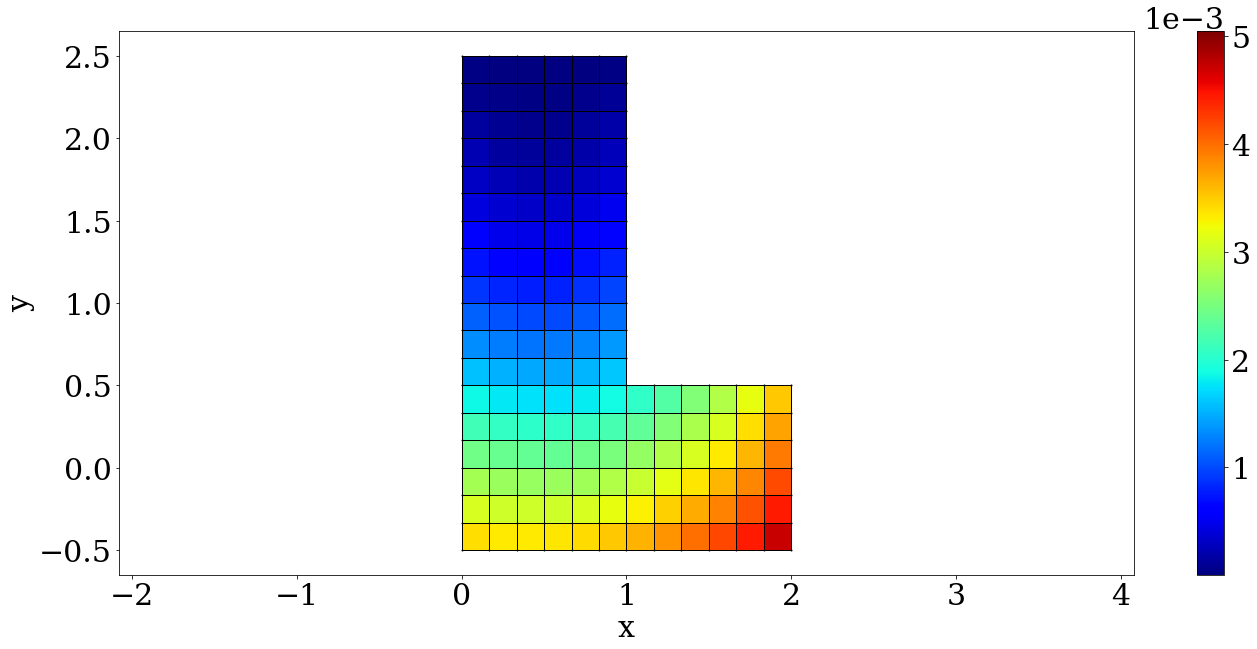

In [ ]:
# Plot Projection mesh
i=0
hole_radius = 0

support_option = np.random.choice(support_options)
if support_option == "MBB" or support_option == "dual_cantilever" :
  force_option = np.random.choice(["top_distributed"])
  mesh_builder = build_mesh
  mesh_processor = dual_mesh_pre_process
elif support_option == "L_bracket" :
  force_option = "side_center"
  mesh_builder = build_mesh_L_bracket
  mesh_processor = dual_mesh_pre_process_L_bracket
else :
  force_option = np.random.choice(force_options)
  mesh_builder = build_mesh
  mesh_processor = dual_mesh_pre_process

m1_p, m2_p = m1p_list[i], m2p_list[i]


if hole_radius != 0 :
  mesh_builder = build_mesh_hole
  mesh_p, element_density_p = mesh_builder(elem_type, m1_p, m2_p, bound_x, bound_y,
                  "posi", 0.0, 0.0, radius=hole_radius)
else :
  mesh_p = mesh_builder(elem_type, m1_p, m2_p, bound_x, bound_y,
                  "posi", 0.0, 0.0)
  element_density_p = [1]*mesh_p.n_elem

# LOW-FIDELITY FEA
surf_nodes_p  = [1]*mesh_p.n_node
void_nodes_p  = [1]*mesh_p.n_node
base_material_p = assign_material(elem_type, mesh_p, E, v, element_density_p)
bc_p = assign_BC_option(mesh_p, force_vals, force_dofs, body_force, support_option, force_option)
fea_p = assemble_matrices(elem_type, mesh_p, base_material_p, bc_p, False)
results_p = solve_FEA(mesh_p, bc_p, fea_p)

disp_proj = (results_p.UUR.T[:,0]**2 + results_p.UUR.T[:,1]**2)**0.5
plot_elem_avg(mesh_p, get_elem_avg(mesh_p, disp_proj),
              color_min = c_min, color_max = c_max)   

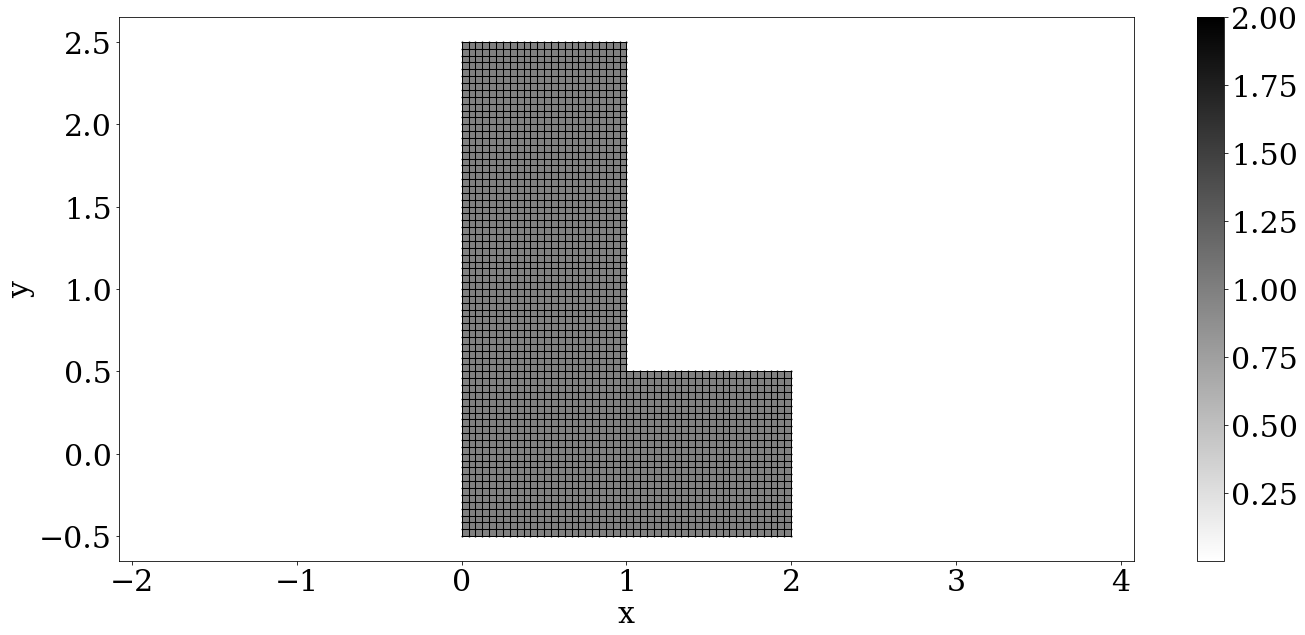

In [ ]:
plot_elem_avg(mesh, np.array(raw_gen[0][2].elem_density),
              plt_cm = plt.cm.binary,
              color_min = 0.001, color_max = 2)  

## Conforming mesh, biameterial, hole

In [ ]:
bound_x = (0.0, 2.0)
bound_y = (-0.5, 0.5)
hole_r = 0.2

force_dofs = [0, 1]
force_vals = [0, -1e7]
body_force = [0.0, 0.0]
vol_frac_min_max = (1.0, 1.0)
density_min_max = (1.0, 1.0)
support_options = ["left_cantilever"] # ["left_cantilever", "right_cantilever", "dual_cantilever", "MBB"]
force_options = ["side_center"] # ["side_center", "side_bottom", "side_top", "top_center", "top_distributed"]
multi_fidelity_opt, KUR_opt, random_bound_opt, random_force_opt = True, False, False, False
force_scale = (-1.0, 1.0)
########################################################################

# Gen params 0.
data_size_gen = 1
batch_size_gen = 1
m1_min_max_gen = (8, 9) 
m2_min_max_gen = (4, 5) 
refine_fact_gen = (0.0, 0.0) 
coord_noise_min_max_gen = (0.0, 0.0)
noise_type_gen = "posi" 

# Test data 0.
multiscale_min_max_m1 = (2, 4) 
multiscale_min_max_m2 = (2, 4) 
m1_list = [48]
m2_list = [int(val/2) for val in m1_list]
m1p_list = [12]
m2p_list = [int(val/2) for val in m1p_list]
M1_list = [12]
M2_list = [int(val/2) for val in M1_list]

raw_gen, input_graph_list_gen, simulated_graph_list_gen, graph_recovery_gen = generate_convergence_data(
     M1_list, M2_list, m1p_list, m2p_list, m1_list, m2_list, refine_fact_gen, vol_frac_min_max, density_min_max, noise_type_gen, coord_noise_min_max_gen,
    support_options, force_options, multi_fidelity_opt, KUR_opt, random_bound_opt, random_force_opt,
     elem_type, bound_x, bound_y, E, v, force_vals, force_dofs, body_force,
     multiscale_min_max_m1, multiscale_min_max_m2, force_scale,
     hole_radius = hole_r)  
initial_conditions_gen, true_deformation_gen = generate_raw_data(input_graph_list_gen, simulated_graph_list_gen ,
                                                                              batch_size_gen + 1)

input_graph_gen = sess.run(initial_conditions_gen)
target_gen = sess.run(true_deformation_gen)
input_graph_gen, local_means_gen, local_stds_gen, local_edge_means_gen, local_edge_stds_gen = normalize_input_list_informed_multiscale(input_graph_gen, input_stats)
input_graph_gen = trim_input_informed_multiscale(input_graph_gen)

output_ops_gen = model(initial_conditions_ph)



Stat mesh: 12 x 6 || Father mesh: 12 x 6 || Child mesh: 48 x 24 || Force Vals: 0.0000, -10000000.0000 || left_cantilever, side_center || (0.0, 2.0) x (-0.5, 0.5)
Projection Error: avg 0.1003, max 3.3507, min -0.4001
Pass:  0.0005465144397253432


In [ ]:
start_time = time.time()
graph_recovery_tst = graph_recovery_gen
local_means_tst = local_means_gen
local_stds_tst = local_stds_gen
input_graph_tst = input_graph_gen
target_tst = target_gen
local_edge_means_tst = local_edge_means_gen
local_edge_stds_tst = local_edge_stds_gen

fea_uur = []
ml_uur_nodes = []
ml_uur_edges = []
logged_elems = []
logged_L2_fea = []
logged_L2_ml = []
uur_lengths = []
logged_uur = []
logged_err_avg_fea = []
logged_err_max_fea = []
logged_err_min_fea = []
logged_err_avg_ml = []
logged_err_max_ml = []
logged_err_min_ml = []
father_idx = 0
father_idxs = [0, 2*12*6]
idx_con = 0

fea_sub_graph_list = graph_recovery_tst[father_idx][0]
graph_nodes = graph_recovery_tst[father_idx][1]
graph_edges = graph_recovery_tst[father_idx][2]

loss_sub_graph_list = copy.deepcopy(fea_sub_graph_list)
model_sub_graph_list = []
input_sub_graph_list = []
target_sub_graph_list = []
for i in range(len(fea_sub_graph_list)) :
  data_idx = i + father_idxs[idx_con]
  feed_dict_2_ge = create_feed_dict(data_idx, input_graph_tst, target_tst, local_means_tst, local_stds_tst, local_edge_means_tst, local_edge_stds_tst,
                              initial_conditions_ph, true_deformation_ph, local_means_ph, local_stds_ph, local_edge_means_ph, local_edge_stds_ph)
  test_values = sess.run({
        "inputs" : initial_conditions_ph,
        "target": true_deformation_ph,
        "loss": loss_op_2_ge,
        "outputs": output_ops_2_ge
        }, feed_dict = feed_dict_2_ge)
  output_ops = test_values["outputs"]
  target_op = target_tst[data_idx]
  x_norm = (target_op.nodes[..., 0:1] - local_means_tst[data_idx][0]) /  local_stds_tst[data_idx][0]
  y_norm = (target_op.nodes[..., 1:2] - local_means_tst[data_idx][1]) / local_stds_tst[data_idx][1]
  SE_x = ((output_ops[0][..., 0:1] - x_norm)**2)
  SE_y = ((output_ops[0][..., 1:2] - y_norm)**2)
  loss_sub_graph_list[i]["nodes"] = np.concatenate([x_norm, y_norm, SE_x, SE_y], axis = 1)

  input_sub_graph_list.append(test_values["inputs"])
  target_sub_graph_list.append(test_values["target"])
  model_sub_graph_list.append(test_values["outputs"])

target_nodes, target_edges = recover_system_nodes_edges(
    "target", fea_sub_graph_list, graph_nodes, graph_edges, local_means_tst[father_idxs[idx_con]: father_idxs[idx_con+1]], local_stds_tst[father_idxs[idx_con]: father_idxs[idx_con+1]], 
                                                                local_edge_means_tst[father_idxs[idx_con]: father_idxs[idx_con+1]], local_edge_stds_tst[father_idxs[idx_con]: father_idxs[idx_con+1]])
target_receivers, target_senders = return_senders_receivers(fea_sub_graph_list, graph_nodes, graph_edges)
input_nodes, input_edges = recover_system_nodes_edges("input", input_sub_graph_list, graph_nodes, graph_edges, 
                                                                local_means_tst[father_idxs[idx_con]: father_idxs[idx_con+1]], local_stds_tst[father_idxs[idx_con]: father_idxs[idx_con+1]], 
                                                                local_edge_means_tst[father_idxs[idx_con]: father_idxs[idx_con+1]], local_edge_stds_tst[father_idxs[idx_con]: father_idxs[idx_con+1]])
model_nodes, model_edges = recover_system_nodes_edges("model", model_sub_graph_list, graph_nodes, graph_edges, 
                                                                local_means_tst[father_idxs[idx_con]: father_idxs[idx_con+1]], local_stds_tst[father_idxs[idx_con]: father_idxs[idx_con+1]], 
                                                                local_edge_means_tst[father_idxs[idx_con]: father_idxs[idx_con+1]], local_edge_stds_tst[father_idxs[idx_con]: father_idxs[idx_con+1]])
projection_nodes, projection_edges = recover_system_nodes_edges("projection", input_sub_graph_list, graph_nodes, graph_edges, 
                                                       local_means_tst[father_idxs[idx_con]: father_idxs[idx_con+1]], local_stds_tst[father_idxs[idx_con]: father_idxs[idx_con+1]], 
                                                                local_edge_means_tst[father_idxs[idx_con]: father_idxs[idx_con+1]], local_edge_stds_tst[father_idxs[idx_con]: father_idxs[idx_con+1]])


input_gt = graphs.GraphsTuple(nodes=input_nodes,
          edges=input_edges,
          globals=[],
          receivers=list([int(val) for val in target_receivers]),
          senders=list([int(val) for val in target_senders]),
          n_node=[],
          n_edge=[])

fea_uur_nodes = get_node_trajectories(target_nodes,1, 0, 2)[0]
ml_edges = uur_from_edges(input_gt, (model_nodes, model_edges[..., 0:2]),  [[0]*2, [1]*2]*2)
ml_nodes = get_node_trajectories(model_nodes,1, 0, 2)[0]



ML Relative Error: avg 0.0674, max 2.3630, min 0.0000
Projection Relative Error: avg 0.1003, max 3.3507, min 0.0000


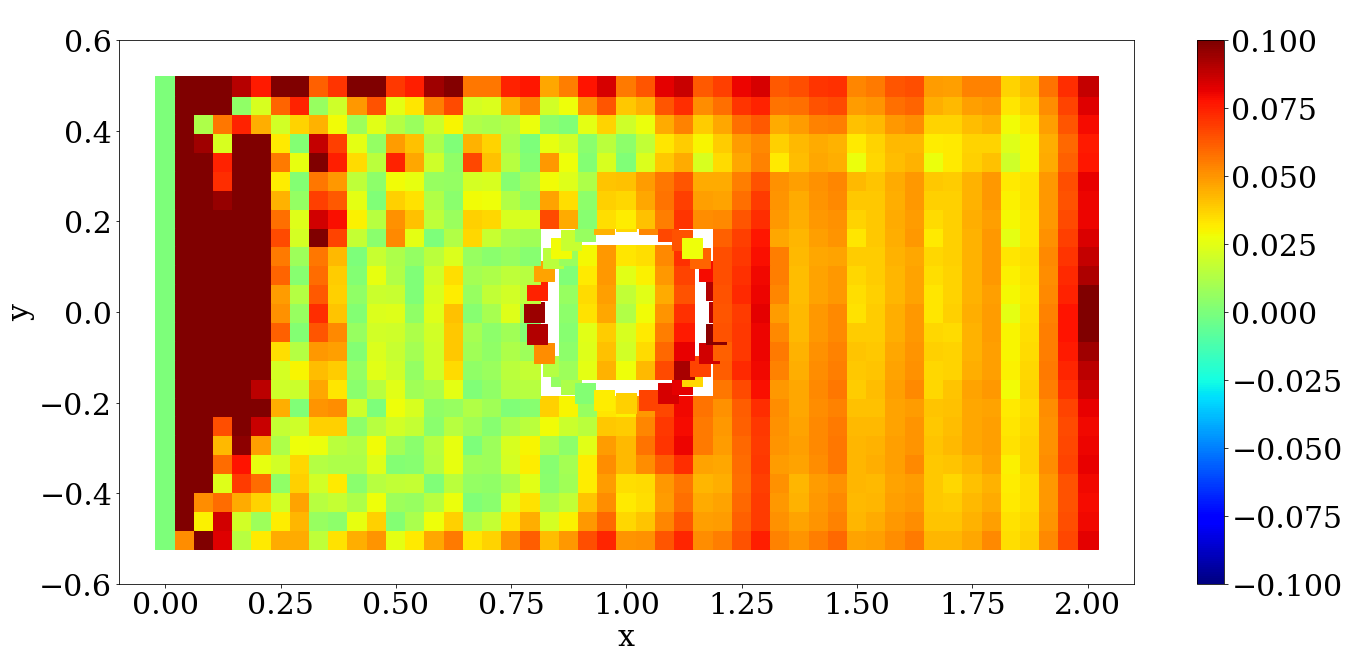

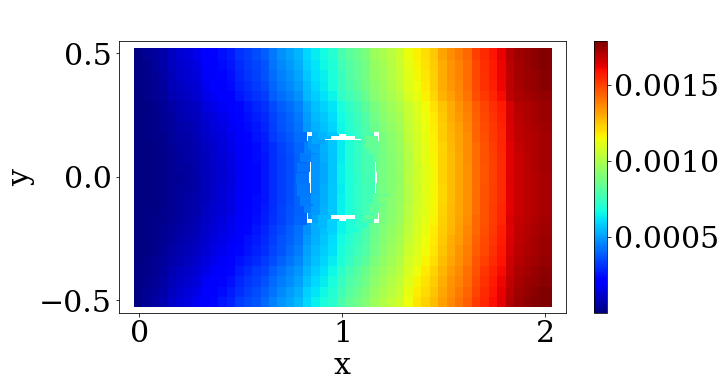

In [ ]:
font = {'family' : 'Verdana',
        'weight' : 'normal',
        'size'   : 30}
from matplotlib import rcParams
mpl.rc('font', **font)
lw = 4
rcParams['font.family'] = 'serif'
rcParams['font.sans-serif'] = ['Tahoma']
cap = 0.1
size = 400
use_nodal_uur = True
###########################################################
idx = 0

m1, m2 = m1_list[idx], m2_list[idx]
uur_fea = fea_uur_nodes
if use_nodal_uur :
  uur_ml = ml_nodes
else :
  uur_ml = ml_edges
x, y = np.asarray(raw_gen[idx][0].coords).T

disp_fea = (uur_fea[..., 0]**2 + uur_fea[..., 1]**2)**0.5
disp_ml = (uur_ml[..., 0]**2 + uur_ml[..., 1]**2)**0.5
disp_proj =  (projection_nodes[..., 0]**2 + projection_nodes[..., 1]**2)**0.5
with warnings.catch_warnings():
  warnings.simplefilter("ignore")
  err_tst_ml = np.nan_to_num(np.abs(disp_fea - disp_ml) / disp_fea, posinf = 0, neginf =0)
  err_proj = np.nan_to_num(np.abs(disp_fea - disp_proj) / disp_fea, posinf = 0, neginf =0)

avg_err_ml = sum(err_tst_ml) / len(err_tst_ml)
max_ml = err_tst_ml.max()
min_ml = err_tst_ml.min()
print("ML Relative Error: avg {:.4f}, max {:.4f}, min {:.4f}".format(avg_err_ml, max_ml, min_ml))

avg_err_proj = sum(err_proj) / len(err_proj)
max_proj = err_proj.max()
min_proj = err_proj.min()
print("Projection Relative Error: avg {:.4f}, max {:.4f}, min {:.4f}".format(avg_err_proj, max_proj, min_proj))


plot_capped_nodal_vect(x,y,err_tst_ml," ", size, -cap, cap)
plot_nodal_vect(x, y, disp_ml, " ", size/3)

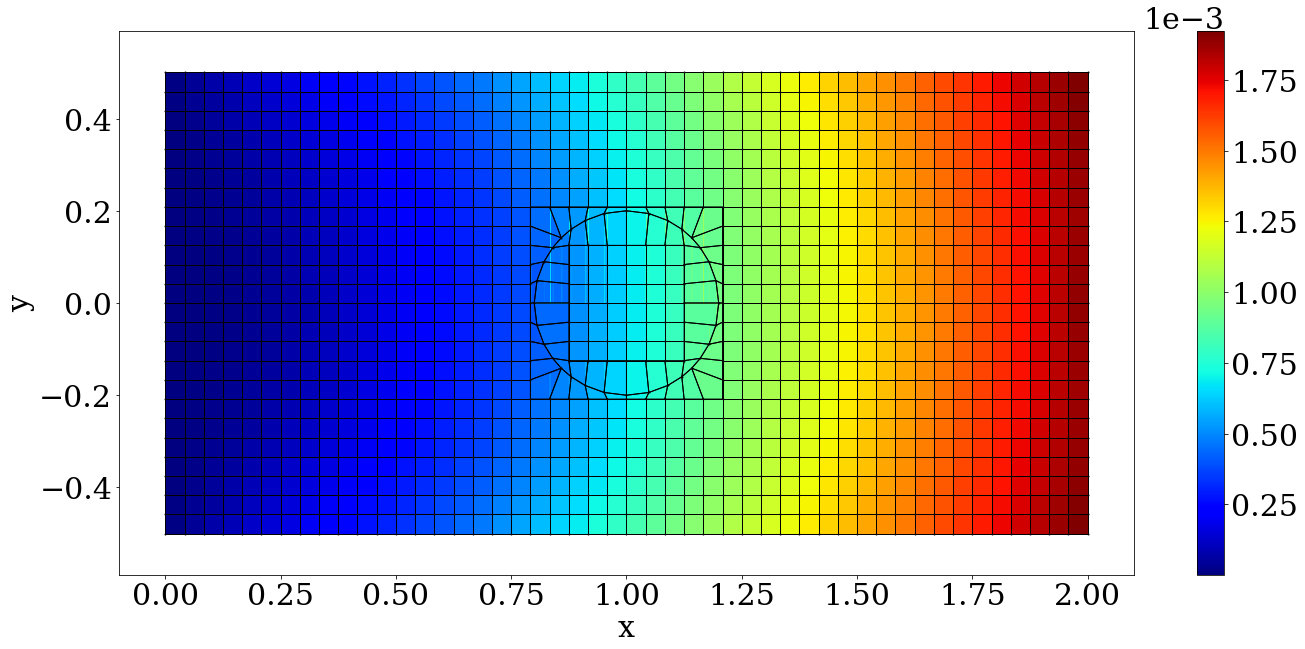

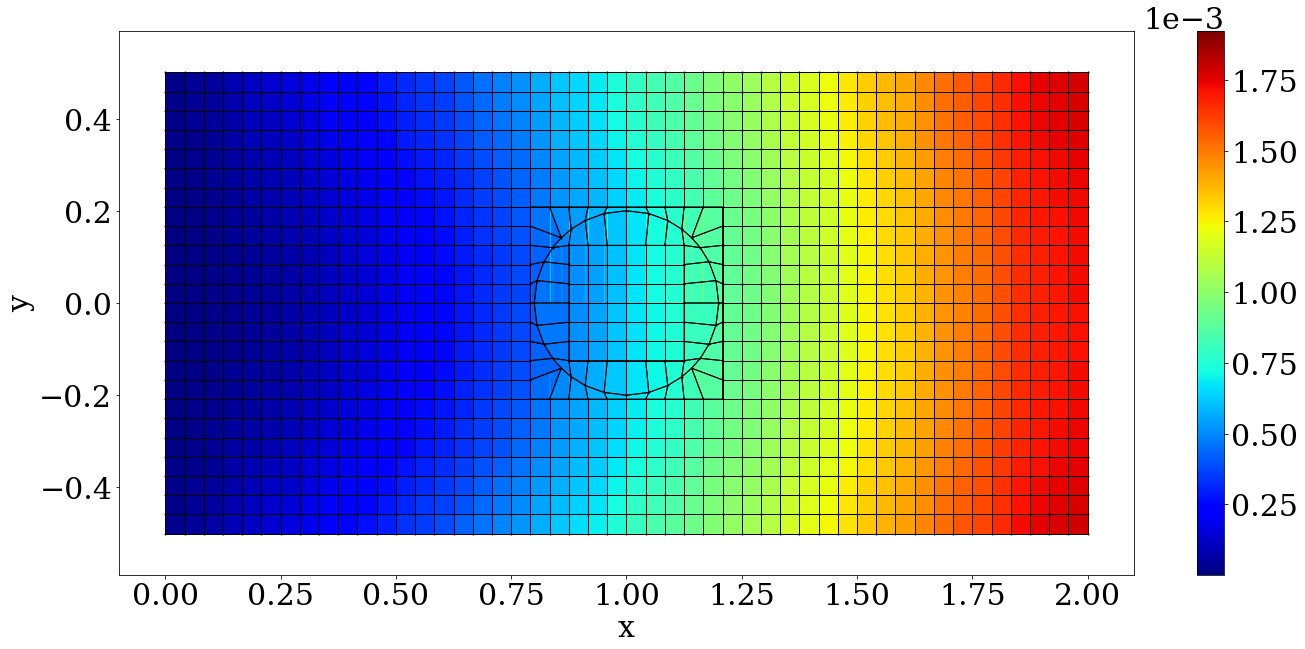

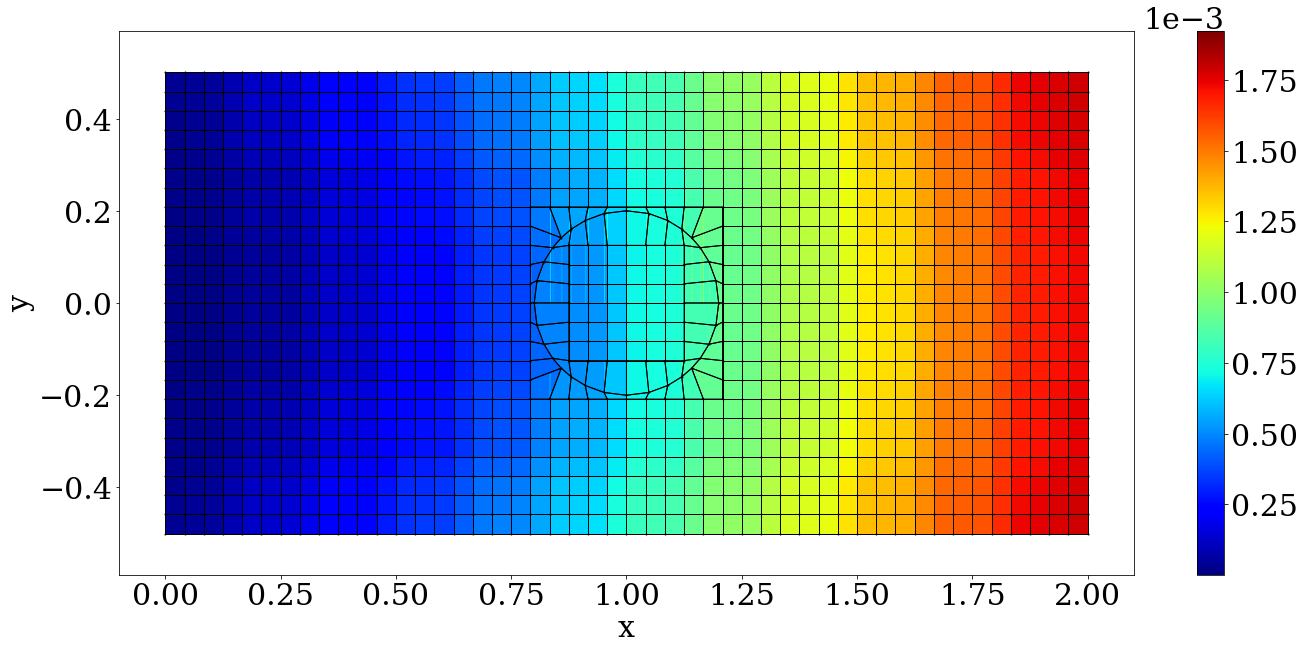

In [ ]:
font = {'family' : 'Verdana',
        'weight' : 'normal',
        'size'   : 30}
from matplotlib import rcParams
mpl.rc('font', **font)
lw = 4
rcParams['font.family'] = 'serif'
rcParams['font.sans-serif'] = ['Tahoma']
mesh = raw_gen[0][0]

true_attr = get_elem_avg(mesh, disp_fea)
c_min, c_max = np.amin(true_attr), np.amax(true_attr)
plot_elem_avg(mesh, true_attr) 
plot_elem_avg(mesh, get_elem_avg(mesh, disp_ml),
              color_min = c_min, color_max = c_max) 
plot_elem_avg(mesh, get_elem_avg(mesh, disp_proj),
              color_min = c_min, color_max = c_max)  

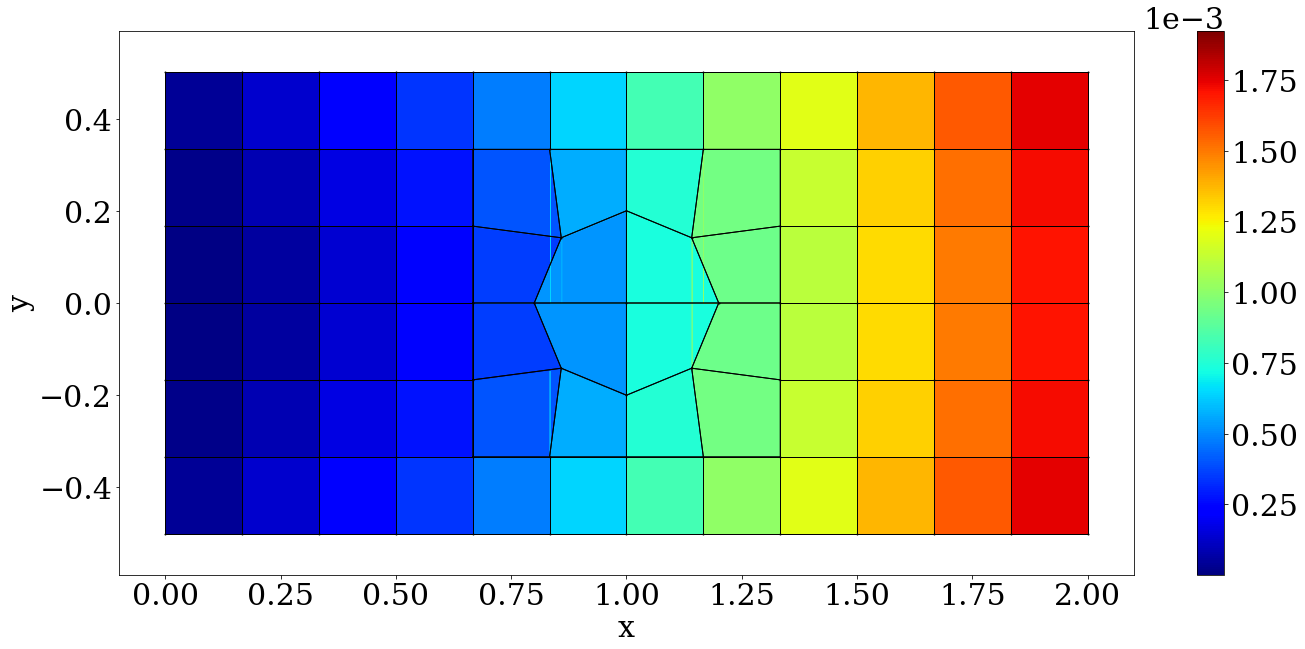

In [ ]:
# Plot Projection mesh
i=0
hole_radius = hole_r

support_option = np.random.choice(support_options)
if support_option == "MBB" or support_option == "dual_cantilever" :
  force_option = np.random.choice(["top_distributed"])
  mesh_builder = build_mesh
  mesh_processor = dual_mesh_pre_process
elif support_option == "L_bracket" :
  force_option = "side_center"
  mesh_builder = build_mesh_L_bracket
  mesh_processor = dual_mesh_pre_process_L_bracket
else :
  force_option = np.random.choice(force_options)
  mesh_builder = build_mesh
  mesh_processor = dual_mesh_pre_process

m1_p, m2_p = m1p_list[i], m2p_list[i]


if hole_radius != 0 :
  mesh_builder = build_mesh_hole
  mesh_p, element_density_p = mesh_builder(elem_type, m1_p, m2_p, bound_x, bound_y,
                  "posi", 0.0, 0.0, radius=hole_radius)
else :
  mesh_p = mesh_builder(elem_type, m1_p, m2_p, bound_x, bound_y,
                  "posi", 0.0, 0.0)
  element_density_p = [1]*mesh_p.n_elem

# LOW-FIDELITY FEA
surf_nodes_p  = [1]*mesh_p.n_node
void_nodes_p  = [1]*mesh_p.n_node
base_material_p = assign_material(elem_type, mesh_p, E, v, element_density_p)
bc_p = assign_BC_option(mesh_p, force_vals, force_dofs, body_force, support_option, force_option)
fea_p = assemble_matrices(elem_type, mesh_p, base_material_p, bc_p, False)
results_p = solve_FEA(mesh_p, bc_p, fea_p)

disp_p = (results_p.UUR.T[:,0]**2 + results_p.UUR.T[:,1]**2)**0.5
plot_elem_avg(mesh_p, get_elem_avg(mesh_p, disp_p),
              color_min = c_min, color_max = c_max)  

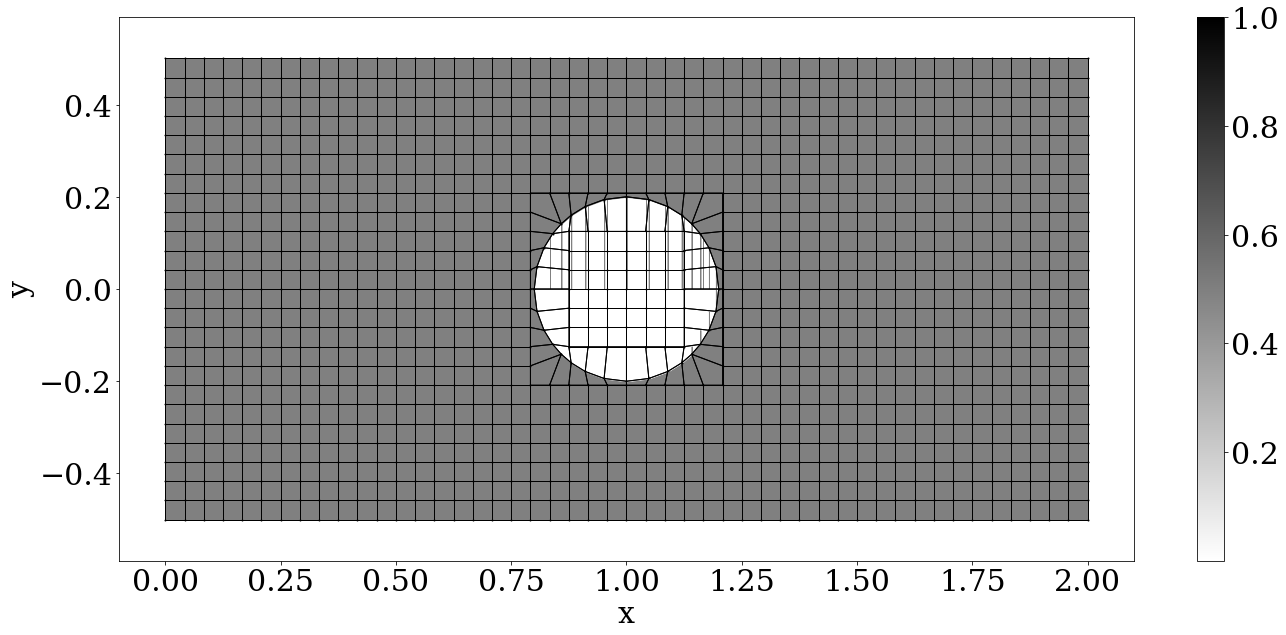

In [ ]:
plot_elem_avg(mesh, 0.5*np.array(raw_gen[0][2].elem_density),
              plt_cm = plt.cm.binary,
              color_min = 0, color_max = 1)  